In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma
import time

In [229]:
# To supress the scientific notation for easier reading.
np.set_printoptions(suppress=True)

In [282]:
df = pd.read_csv('../data/clean_dataset.csv', converters={'point': pd.eval})
df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim.reset_index(inplace=True, drop=True)
df_prim_enroll = df_prim['grade7_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec.reset_index(inplace=True, drop=True)
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

In [244]:
# Perform imports here:
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px

In [251]:
relevant = df[['region','nearest_lwr_sec']]

In [252]:
# Present key statistics.
relevant.groupby('region').describe()

nearest_lwr_sec                                            \
                           count       mean        std       min       25%   
region                                                                       
Addis Ababa                192.0   0.940109   0.826780  0.004207  0.458554   
Afar                        14.0   7.536316   6.070018  0.953155  2.959475   
Amhara                    5145.0   7.972508   6.184954  0.000000  3.624363   
Benishangul Gumz           302.0   9.090908   8.209770  0.000000  3.256987   
Dire Dawa                   52.0   7.035098   6.078662  0.011020  1.334921   
Harari                      43.0   3.607201   2.671218  0.106456  1.526998   
Oromia                    9517.0   6.384680   5.777694  0.000467  2.254889   
SNNP                      1782.0   4.688752   3.653129  0.001685  2.380314   
Somali                     338.0  26.006816  22.331691  0.001112  9.542989   
Tigray                    1133.0   7.716232   6.226557  0.000552  3.194200   

                                                    
                        50%        75%         max  
region                                              
Addis Ababa        0.784813   1.207269    6.832689  
Afar               5.363687  11.170332   18.289468  
Amhara             6.901752  10.737745   55.492769  
Benishangul Gumz   6.629467  13.334280   54.846156  
Dire Dawa          5.838220  10.834329   25.928011  
Harari             3.266570   4.895817   10.115230  
Oromia             5.285359   8.686222   62.965292  
SNNP               4.073417   6.224795   57.806122  
Somali            20.900161  36.507064  133.384496  
Tigray             6.046929  10.893435   37.677732

In [267]:
test = df.groupby('region').sum().reset_index()

In [268]:
fig = px.bar(test, x="region", y=['grade7_8', 'grade9_10'], barmode='group')
fig.show()

In [275]:
df.groupby(['region'])['gr_offer'].value_counts()

region            gr_offer
Addis Ababa       G.1-8        191
                  G. 9-10       40
                  G. 9-12       14
                  G. 11-12       9
                  G.1-4          9
                  G.5-8          1
Afar              G.1-8         14
                  G.1-4          8
                  G. 9-12        4
                  G. 9-10        1
Amhara            G.1-8       5145
                  G.1-4       2197
                  G. 9-12      185
                  G. 9-10      182
                  G. 11-12      17
Benishangul Gumz  G.1-8        298
                  G.1-4        194
                  G. 9-10       43
                  G. 9-12       21
                  G.5-8          4
Dire Dawa         G.1-8         52
                  G. 9-10        4
                  G.1-4          1
Harari            G.1-8         41
                  G.1-4         13
                  G. 9-10        4
                  G.5-8          2
                  G. 11-12  

In [284]:
# create a color scheme to use throughout for the different regions for consistency. 
color_discrete_map = {'AA':'#FECB52', 'Afar':'#00CC96', 'Amhara':'#636EFA',
                      'BG':'#FF97FF','DD':'#FF6692','Harari':'#19D3F3', 'Oromia':'#FFA15A',
                      'SNNP':'#B6E880','Somali':'#AB63FA', 'Tigray':'#EF553B'}

In [285]:
fig = px.scatter(df_prim, y="grade5_8", 
                 x="nearest_lwr_sec", size="grade5_8", color="region",
                 hover_name="region", color_discrete_map = color_discrete_map, 
                title='Distance of upper primary schools to lower secondary schools')
fig.show()


# Test Development

In developing the code, three main tests have been completed within one region: Amhara. The first at a very micro level with a custom dummy dataset with only two primary schools and 2 proposed secondary schools. The second is for one woreda/district with 21 primary schools and two secondary schools, whereby 5 secondary schools are proposed. The final test was a region wide test with 1765 primary schools and 1658 secondary schools, with 5 new secondary schools proposed.

In [230]:
# Specify which test to perform
declare_test =3 # micro test

In [231]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('../data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('../eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2:
    df = pd.read_csv('../data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('../eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else:
    proposed_schools= 10
    df = pd.read_csv('../data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('../eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

## Data Preparation

In [232]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([ 8.71481253, 35.26108445,  8.71481253, 35.26108445,  8.71481253,
        35.26108445,  8.71481253, 35.26108445,  8.71481253, 35.26108445,
         8.71481253, 35.26108445,  8.71481253, 35.26108445,  8.71481253,
        35.26108445,  8.71481253, 35.26108445,  8.71481253, 35.26108445]),
 array([13.76296565, 40.21243796, 13.76296565, 40.21243796, 13.76296565,
        40.21243796, 13.76296565, 40.21243796, 13.76296565, 40.21243796,
        13.76296565, 40.21243796, 13.76296565, 40.21243796, 13.76296565,
        40.21243796, 13.76296565, 40.21243796, 13.76296565, 40.21243796])]

In [233]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim.reset_index(inplace=True, drop=True)
df_prim_enroll = df_prim['grade7_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec.reset_index(inplace=True, drop=True)
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

In [234]:
total_sec = len(df_sec_enroll)+ proposed_schools
total_sec

377

In [235]:
dd = df_prim[df_prim['nearest_lwr_sec'] >5]
dd = dd.sort_values(['grade7_8'], ascending=False).head(5)

In [236]:
benchmark = sum(dd['grade7_8'])
benchmark

4286

In [237]:
benchmark_loc = dd['point'].reset_index(drop=True).to_numpy()
benchmark_loc = np.array([np.array(i) for i in benchmark_loc], dtype=float)

In [238]:
f2(benchmark_loc)

ValueError: cannot reshape array of size 10 into shape (10,2)

In [239]:
df_prim['expected_enroll'] = shape(df_prim['nearest_lwr_sec'], df_prim['grade7_8'])
df_prim

<ipython-input-239-440b653dbfa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prim['expected_enroll'] = shape(df_prim['nearest_lwr_sec'], df_prim['grade7_8'])


,region,zone,woreda,school_name,school_code,geometry,lat,lon,gr_offer,urban_rural,...,ADM0_EN,ADM1_EN,ADM2_EN,ADM3_EN,point,nearest_up_prim,nearest_sch_code,nearest_lwr_sec,nearest_up_sec,expected_enroll
0,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meklit,S0306020332,POINT (37.79732 11.077843),11.077843,37.79732,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.077843, 37.79732]",NaN,S0306180503,8.653923,NaN,0.0
1,Amhara,Misrak Gojjam,Sedie,Grarema,S0306020292,POINT (37.9104 10.7492),10.749200,37.91040,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.7492, 37.9104]",NaN,S0306012833,13.340141,NaN,0.0
2,Amhara,Misrak Gojjam,Sedie,Jema,S0306025422,POINT (37.8078 10.88),10.880000,37.80780,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.88, 37.8078]",NaN,S0306025393,1.156893,NaN,0.0
3,Amhara,Misrak Gojjam,Sedie,Tadesso,S0306020802,POINT (37.904 10.8312),10.831200,37.90400,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.8312, 37.904]",NaN,S0306020393,11.022295,NaN,0.0
4,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meshegie,S0306020012,POINT (38.0231 11.1319),11.131900,38.02310,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.1319, 38.0231]",NaN,S0306020743,16.076289,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140,Amhara,Agew awi,Jawi,Berawi,S0309060372,POINT (36.4249 11.6358),11.635800,36.42490,G.1-8,1,...,Ethiopia,Amhara,Awi,Jawi,"[11.6358, 36.4249]",NaN,S0309060413,11.161335,NaN,0.0
5141,Amhara,Agew awi,Jawi,Kumbir,S0309060392,POINT (36.527 11.7004),11.700400,36.52700,G.1-8,1,...,Ethiopia,Amhara,Awi,Jawi,"[11.7004, 36.527]",NaN,S0309060413,15.093627,NaN,0.0
5142,Amhara,Semen Wollo,Habro,Dulie Chefie,S0303080222,POINT (39.6616 11.661),11.661000,39.66160,G.1-8,1,...,Ethiopia,Amhara,North Wello,Mersa Town,"[11.661, 39.6616]",NaN,S0303080343,0.631538,NaN,283.0
5143,Amhara,Semen Wollo,Habro,Meneyu kelena,S0303080372,POINT (39.6573 11.6703),11.670300,39.65730,G.1-8,1,...,Ethiopia,Amhara,North Wello,Mersa Town,"[11.6703, 39.6573]",NaN,S0303080343,0.948555,NaN,29.0


In [176]:
def final_expected_enroll(prim_enroll, x, prim_loc, current_ds):
    feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
    eei = 0 # expected enrollment increase
    d = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True) # distance of PS to x. 
    closest = [get_close_schools(d[i], current_dist) for i in range(proposed_schools)] # keep only those < 5 and < current_dist
    
    for ss in range(proposed_schools):
        for ps in range(len(closest[ss])):
            closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
            if closest_prim[0] not in feeder:
                feeder[closest_prim[0]] = [ss, closest_prim[1]] # if not in feeder, add to feeder dict.
            
            elif (closest_prim[1] < feeder[closest_prim[0]][1]): # if another SS is closer, replace in feeder 
                feeder[closest_prim[0]] = [ss, closest_prim[1]]
            
            # Current estimated enrollment feeding into current SS
            distance_current = shape(current_dist[closest_prim[0]], prim_enroll[closest_prim[0]])
#             df_prim.loc[0, 'expected_enroll'] = distance_current   
    
    # eei is only the final min schools being added.
    closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
    ps_enroll = prim_enroll[list(feeder.keys())]
    eei = np.sum(shape(closest_ss_dist, ps_enroll))
    


In [181]:
df_prim.iloc[3616]

region                                          Amhara
zone                                      Mirab Gojjam
woreda                                     Semen Mecha
school_name                                    Enamert
school_code                                S0307040322
geometry                   POINT (37.180286 11.418338)
lat                                            11.4183
lon                                            37.1803
gr_offer                                         G.1-8
urban_rural                                          1
grade7                                              50
grade8                                              39
grade7_8                                            89
grade1_4                                           241
grade1_4_f                                         110
grade1_4_m                                         131
grade5_8                                           183
grade5_8_f                                          97
grade5_8_m

In [180]:
df_prim.loc[3616, 'expected_enroll']

89.0

In [214]:
%%time
ee_old = np.sum(df_sec_enroll)
feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
eei = 0 # expected enrollment increase
d = haversine_vector(df_prim_loc, benchmark_loc, Unit.KILOMETERS, comb=True) # distance of PS to x. 
closest = [get_close_schools(d[i], current_ps_distance) for i in range(proposed_schools)] # keep only those < 5 and < current_dist

for ss in range(proposed_schools):
    for ps in range(len(closest[ss])):
        closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
        if closest_prim[0] not in feeder:
            feeder[closest_prim[0]] = [ss, closest_prim[1]] # if not in feeder, add to feeder dict.

        elif (closest_prim[1] < feeder[closest_prim[0]][1]): # if another SS is closer, replace in feeder 
            feeder[closest_prim[0]] = [ss, closest_prim[1]]

        # Current estimated enrollment feeding into current SS
        distance_current = shape(current_ps_distance[closest_prim[0]], df_prim_enroll[closest_prim[0]])
        df_prim.loc[closest_prim[0], 'expected_enroll'] = shape(closest_prim[1], df_prim_enroll[closest_prim[0]])
        df_prim.loc[closest_prim[0], 'expected_enroll'] -= distance_current
        df_prim.loc[closest_prim[0], 'nearest_sch_code'] = ss
        df_prim.loc[closest_prim[0], 'nearest_lwr_sec'] = closest_prim[1]
        ee_old -= distance_current

# eei is only the final min schools being added.
closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
ps_enroll = df_prim_enroll[list(feeder.keys())]
eei = shape(closest_ss_dist, ps_enroll)

Wall time: 45.2 ms


In [215]:
np.sum(eei) + ee_old

440996.46568223636

In [216]:
sum(df_prim.groupby(['nearest_sch_code'])['expected_enroll'].agg('sum')[:5])

6372.465682236335

In [204]:
ee_old

434624.0

In [144]:
shape(1.8874856949351653, 89)

array(89.)

In [149]:
df_prim.iloc[3616]

region                                          Amhara
zone                                      Mirab Gojjam
woreda                                     Semen Mecha
school_name                                    Enamert
school_code                                S0307040322
geometry                   POINT (37.180286 11.418338)
lat                                            11.4183
lon                                            37.1803
gr_offer                                         G.1-8
urban_rural                                          1
grade7                                              50
grade8                                              39
grade7_8                                            89
grade1_4                                           241
grade1_4_f                                         110
grade1_4_m                                         131
grade5_8                                           183
grade5_8_f                                          97
grade5_8_m

In [120]:
closest_prim

[3853, 3.109267244572558]

In [121]:
feeder.keys()

dict_keys([3849, 3853])

In [91]:
df_prim.loc

5145

In [90]:
feeder

{3609: [0, 4.978304510828018],
 3616: [0, 1.8874856949351653],
 4943: [0, 0.0],
 4944: [0, 0.8494231411039805],
 5108: [1, 0.0],
 5111: [1, 0.3667032509652573],
 1907: [2, 2.247602371618123],
 1912: [2, 2.98299218962242],
 1926: [2, 2.396826982512762],
 1927: [2, 0.0],
 4110: [3, 2.754598834287644],
 4111: [3, 1.625714519544335],
 4112: [3, 0.0],
 4113: [3, 4.2411441312516915],
 4118: [3, 3.1054059159146625],
 4119: [3, 1.01804045042906],
 4123: [3, 4.999869001545784],
 2250: [4, 0.0],
 2251: [4, 4.5471475328157815],
 2254: [4, 2.3033728851891646],
 2261: [4, 2.522155798861514],
 2270: [4, 2.57716780508435],
 2711: [4, 4.311360114144668],
 2712: [4, 4.606471741842292]}

In [89]:
df_prim

,region,zone,woreda,school_name,school_code,geometry,lat,lon,gr_offer,urban_rural,...,ADM0_EN,ADM1_EN,ADM2_EN,ADM3_EN,point,nearest_up_prim,nearest_sch_code,nearest_lwr_sec,nearest_up_sec,expected_enroll
0,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meklit,S0306020332,POINT (37.79732 11.077843),11.077843,37.79732,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.077843, 37.79732]",NaN,S0306180503,8.653923,NaN,0.0
1,Amhara,Misrak Gojjam,Sedie,Grarema,S0306020292,POINT (37.9104 10.7492),10.749200,37.91040,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.7492, 37.9104]",NaN,S0306012833,13.340141,NaN,0.0
2,Amhara,Misrak Gojjam,Sedie,Jema,S0306025422,POINT (37.8078 10.88),10.880000,37.80780,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.88, 37.8078]",NaN,S0306025393,1.156893,NaN,0.0
3,Amhara,Misrak Gojjam,Sedie,Tadesso,S0306020802,POINT (37.904 10.8312),10.831200,37.90400,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.8312, 37.904]",NaN,S0306020393,11.022295,NaN,0.0
4,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meshegie,S0306020012,POINT (38.0231 11.1319),11.131900,38.02310,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.1319, 38.0231]",NaN,S0306020743,16.076289,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140,Amhara,Agew awi,Jawi,Berawi,S0309060372,POINT (36.4249 11.6358),11.635800,36.42490,G.1-8,1,...,Ethiopia,Amhara,Awi,Jawi,"[11.6358, 36.4249]",NaN,S0309060413,11.161335,NaN,0.0
5141,Amhara,Agew awi,Jawi,Kumbir,S0309060392,POINT (36.527 11.7004),11.700400,36.52700,G.1-8,1,...,Ethiopia,Amhara,Awi,Jawi,"[11.7004, 36.527]",NaN,S0309060413,15.093627,NaN,0.0
5142,Amhara,Semen Wollo,Habro,Dulie Chefie,S0303080222,POINT (39.6616 11.661),11.661000,39.66160,G.1-8,1,...,Ethiopia,Amhara,North Wello,Mersa Town,"[11.661, 39.6616]",NaN,S0303080343,0.631538,NaN,283.0
5143,Amhara,Semen Wollo,Habro,Meneyu kelena,S0303080372,POINT (39.6573 11.6703),11.670300,39.65730,G.1-8,1,...,Ethiopia,Amhara,North Wello,Mersa Town,"[11.6703, 39.6573]",NaN,S0303080343,0.948555,NaN,29.0


In [116]:
np.sum(df_prim['expected_enroll'])

255638.80211127433

In [185]:
np.sum(df_prim['expected_enroll'])

262011.2677935107

In [80]:
df_prim

,region,zone,woreda,school_name,school_code,geometry,lat,lon,gr_offer,urban_rural,...,ADM0_EN,ADM1_EN,ADM2_EN,ADM3_EN,point,nearest_up_prim,nearest_sch_code,nearest_lwr_sec,nearest_up_sec,expected_enroll
0,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meklit,S0306020332,POINT (37.79732 11.077843),11.077843,37.79732,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.077843, 37.79732]",NaN,S0306180503,8.653923,NaN,0.0
1,Amhara,Misrak Gojjam,Sedie,Grarema,S0306020292,POINT (37.9104 10.7492),10.749200,37.91040,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.7492, 37.9104]",NaN,S0306012833,13.340141,NaN,0.0
2,Amhara,Misrak Gojjam,Sedie,Jema,S0306025422,POINT (37.8078 10.88),10.880000,37.80780,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.88, 37.8078]",NaN,S0306025393,1.156893,NaN,0.0
3,Amhara,Misrak Gojjam,Sedie,Tadesso,S0306020802,POINT (37.904 10.8312),10.831200,37.90400,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.8312, 37.904]",NaN,S0306020393,11.022295,NaN,0.0
4,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meshegie,S0306020012,POINT (38.0231 11.1319),11.131900,38.02310,G.1-8,1,...,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.1319, 38.0231]",NaN,S0306020743,16.076289,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140,Amhara,Agew awi,Jawi,Berawi,S0309060372,POINT (36.4249 11.6358),11.635800,36.42490,G.1-8,1,...,Ethiopia,Amhara,Awi,Jawi,"[11.6358, 36.4249]",NaN,S0309060413,11.161335,NaN,0.0
5141,Amhara,Agew awi,Jawi,Kumbir,S0309060392,POINT (36.527 11.7004),11.700400,36.52700,G.1-8,1,...,Ethiopia,Amhara,Awi,Jawi,"[11.7004, 36.527]",NaN,S0309060413,15.093627,NaN,0.0
5142,Amhara,Semen Wollo,Habro,Dulie Chefie,S0303080222,POINT (39.6616 11.661),11.661000,39.66160,G.1-8,1,...,Ethiopia,Amhara,North Wello,Mersa Town,"[11.661, 39.6616]",NaN,S0303080343,0.631538,NaN,283.0
5143,Amhara,Semen Wollo,Habro,Meneyu kelena,S0303080372,POINT (39.6573 11.6703),11.670300,39.65730,G.1-8,1,...,Ethiopia,Amhara,North Wello,Mersa Town,"[11.6703, 39.6573]",NaN,S0303080343,0.948555,NaN,29.0


0.0

In [61]:
df_prim.loc[0, 'expected_enroll']

KeyError: 0

In [ ]:
df_prim

## Key functions

In [25]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [26]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    answer = np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            )
    return answer

In [490]:
# OLD FITNESS FUNCTION
def expected_enroll(prim_loc, x, prim_enroll):
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    shaped_enroll = shape(min_d, prim_enroll)
    return np.sum(shaped_enroll)

In [491]:
expected_enroll(df_prim_loc, df_sec_loc, df_prim_enroll)


545041.6638433891

In [492]:
np.sum(df_sec_enroll)

434624.0

In [11]:
# OLD OBJECTIVE FUNCTION
# # The Objective Function with the shape function included.
# def f(x):
#     x = np.append(df_sec_loc, x).reshape(total_sec,2) #  add new schools to existing and reshape
#     test_case = expected_enroll(df_prim_loc, x, df_prim_enroll)
#     return test_case

In [12]:
# Create random points within regional or district boundaries boundaries.

def create_random_sp(sp_type):
    if sp_type == 'region':
        shape_file = gdf_region_shp[0]
    else:
        shape_file = gdf_woreda_shp[0]
    sp_in_bounds = False
    while sp_in_bounds == False:
        sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
        sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
        sp = np.vstack((sp1, sp2)).T
        sp_points = gpd.points_from_xy(sp[:, 1], sp[:, 0])
        if sp_points.within(shape_file).all():
            sp_in_bounds = True
            return sp.flatten()

In [111]:
def generate_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
    sp = np.vstack((sp1, sp2)).T
    return sp

In [13]:
# ee_old_constant = np.sum(df_sec_enroll)
# current_ps_distance = df_prim['nearest_lwr_sec'].to_numpy() # existing distance to secondary school
# def expected_enrollment2(prim_loc, x, prim_enroll, current_dist):
#     ee_old  = ee_old_constant
#     feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
#     eei = 0 # expected enrollment increase
#     d = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True) # primary schools distance to secondary schools
    
#     for ss in range(0, proposed_schools): # for each secondary school
#         for ps in range(0, len(d[ss])): # for each distance from a secondary school to a primary school                         
#             # Case 0
#             # if the distance is less than 5km & the distance is less than the current distance to old secondary school
#             if (d[ss][ps] < 5) & (d[ss][ps] < current_dist[ps]):
#                 if ps not in feeder: # if primary school not in feeder dict, add.
#                     feeder[ps] = [ss, d[ss][ps]] # dict = {primary school: [feeder secondary school, distance of ps to ss]}
#                 else: # if ps already a key in feeder, replace with min [feeder secondary school, distance of ps to ss]
#                     if feeder[ps][1] < d[ss][ps]:
#                         feeder[ps] = [ss, d[ss][ps]]
                        
#                 # case 1
#                 ee_old -= shape(current_dist[ps], prim_enroll[ps]) # remove old secondary students within catchment.
                
#     # eei is only the final min schools being added.
#     closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
#     ps_enroll = prim_enroll[list(feeder.keys())]
#     eei = np.sum(shape(closest_ss_dist, ps_enroll))
#     return eei + ee_old # for overall expected enrollment. 

In [51]:
ee_old_constant = np.sum(df_sec_enroll)
current_ps_distance = df_prim['nearest_lwr_sec'].to_numpy() # existing distance to secondary school
def expected_enrollment3(prim_loc, x, prim_enroll, current_dist):
    ee_old  = ee_old_constant
    feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
    eei = 0 # expected enrollment increase
    d = haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True)
    closest = [get_close_schools(d[i], current_dist) for i in range(proposed_schools)]
    print(closest)
    
    for ss in range(proposed_schools):
        for ps in range(len(closest[ss])):
            closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
            if closest_prim[0] not in feeder:
                feeder[closest_prim[0]] = [ss, closest_prim[1]]
            elif closest_prim[1] < feeder[closest_prim[0]][1]:
                feeder[closest_prim[0]] = [ss, closest_prim[1]]
            # Current estimated enrollment feeding into current SS
            distance_current = shape(current_dist[closest_prim[0]], prim_enroll[closest_prim[0]])
            ee_old -= distance_current # remove old secondary students within catchment.
        
    # eei is only the final min schools being added.
    closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
    ps_enroll = prim_enroll[list(feeder.keys())]
    eei = np.sum(shape(closest_ss_dist, ps_enroll))
    return eei + ee_old # for overall expected enrollment. 

In [694]:
expected_enrollment3(df_prim_loc, generate_random_sp(), df_prim_enroll, current_ps_distance)

435787.69384615595

In [36]:
def get_close_schools(ps, current_ds):
    """ A function that takes as input a list of [x,y] coordinates. Checks to see if s........
    """
    
    # get (index and distance) of schools located less than 5km and less than current distance.
    return [[i, ps[i]] for i in range(len(ps)) if ((ps[i] < 5) & (ps[i] < current_ds[i]))]

In [695]:
feeder = {}
ee_old_constant = np.sum(df_sec_enroll)
ee_old = ee_old_constant


for ss in range(proposed_schools):
    for ps in range(len(closest[ss])):
        closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
        if closest_prim[0] not in feeder:
            feeder[closest_prim[0]] = [ss, closest_prim[1]]
        elif closest_prim[1] < feeder[closest_prim[0]][1]:
            feeder[closest_prim[0]] = [ss, closest_prim[1]]
        else:
            print('NOT SUPPOSED TO BE HERE.')
        # Current estimated enrollment feeding into current SS
        distance_current = shape(current_ps_distance[closest_prim[0]], df_prim_enroll[closest_prim[0]])
        ee_old -= distance_current # remove old secondary students within catchment.


                
# eei is only the final min schools being added.
closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
ps_enroll = df_prim_enroll[list(feeder.keys())]
eei = np.sum(shape(closest_ss_dist, ps_enroll))
ee = eei + ee_old # for overall expected enrollment. 
print(ee)

435533.5520687372


In [28]:
# The Objective Function with the shape function included.
def f2(x):
    x = x.reshape(proposed_schools,2) #  add new schools to existing and reshape
    test_case = expected_enrollment3(df_prim_loc, x, df_prim_enroll, current_ps_distance)
    return test_case*-1

## Random Search

In [685]:
def random_search(f, n, test_type):
    x = [generate_random_sp() for _ in range(n)]
    fx = [[f(xi), xi] for xi in x]
    best_f, best_solution = min(fx, key=lambda x:x[0])
    return best_f, best_solution

In [686]:
%%time
n_starting_points = 30
fx = []
for _ in range(n_starting_points):
    start_time = time.time()
    fx.append([random_search(f2, 100, 'region'), time.time() - start_time])
    print(_, 'starting point completed.')

0 starting point completed.
1 starting point completed.
2 starting point completed.
NOT SUPPOSED TO BE HERE.
3 starting point completed.
4 starting point completed.
5 starting point completed.
6 starting point completed.
7 starting point completed.
NOT SUPPOSED TO BE HERE.
NOT SUPPOSED TO BE HERE.
8 starting point completed.
9 starting point completed.
10 starting point completed.
11 starting point completed.
12 starting point completed.
NOT SUPPOSED TO BE HERE.
NOT SUPPOSED TO BE HERE.


KeyboardInterrupt: 

In [17]:
# %time fx = [random_search(f2, 100, 'region') for _ in range(4)] # OLD

In [18]:
results = pd.DataFrame(columns=['random_starting_point', 'algorithm', 'ee', 'eei', 'proposed_locations', 'time', 'sigma'])

In [19]:
for i in range(0, len(fx)):
    row = (pd.Series({'random_starting_point':i, 'algorithm':'Random Search', 'ee':round(abs(fx[i][0][0]),0),
                                'eei':round(abs(np.sum(df_sec_enroll) - abs(fx[i][0][0])),0), 
                                'proposed_locations': fx[i][0][1], 'time':fx[i][1], 'sigma':'NA'}))
    results = results.append(row, ignore_index=True)

## CMA

In [20]:
results = results.reset_index(drop=True)

In [21]:
sigmas = (0.01, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24)
maxits = 10000

In [22]:
%%time
fcma = []

for i in range(n_starting_points):
    start_time = time.time()
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(create_random_sp('region'), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f2, iterations=maxits / es.popsize)
        fcma.append((es.result[1], es.result[0], (time.time() - start_time), j))

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul  6 23:11:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.378560194543390e+05 1.0e+00 1.03e-02  1e-02  1e-02 0:00.1
    2     20 -4.379883858741494e+05 1.3e+00 1.07e-02  1e-02  1e-02 0:00.3
    3     30 -4.381909117922850e+05 1.4e+00 1.06e-02  1e-02  1e-02 0:00.5
   23    230 -4.388607017748290e+05 2.3e+00 5.95e-03  3e-03  6e-03 0:03.5
   50    500 -4.389803888677144e+05 3.9e+00 2.37e-03  8e-04  3e-03 0:07.6
   84    840 -4.389984482223154e+05 1.1e+01 2.48e-04  4e-05  3e-04 0:12.7
  100   1000 -4.389987660396312e+05 1.6e+01 1.61e-04  2e-05  2e-04 0:15.1
  146   1460 -4.389992028898832e+05 4.6e+01 5.30e-05  3e-06  6e-05 0:22.1
  199   1990 -4.389992800687599e+05 2.1e+02 2.18e-05  1e-06  3e-05 0:30.2
  200   2000 -4.389992827872818e+05 2.2e+02 2.16e-05  1e-06  3e-05 0:30.3
  267   2670 -4.389992981603189e+05 6.1e+02 5.11e-06  3e-07  6e-06 0:40.4
  300   3000 -4.38999298

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul  6 23:21:20 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.373624188351636e+05 1.0e+00 1.52e-01  1e-01  2e-01 0:00.2
    2     20 -4.358958400328662e+05 1.2e+00 1.45e-01  1e-01  2e-01 0:00.3
    3     30 -4.357657457569274e+05 1.3e+00 1.34e-01  1e-01  1e-01 0:00.5
   23    230 -4.421220317756010e+05 2.5e+00 1.16e-01  9e-02  1e-01 0:03.5
   50    500 -4.380167742298566e+05 5.0e+00 1.15e-01  6e-02  2e-01 0:07.6
   83    830 -4.406189142860093e+05 5.9e+00 3.55e-02  1e-02  4e-02 0:12.7
  100   1000 -4.415688788410370e+05 6.4e+00 1.66e-02  5e-03  2e-02 0:15.3
  146   1460 -4.423165470318173e+05 7.8e+00 1.30e-02  3e-03  2e-02 0:22.4
  198   1980 -4.424847335975860e+05 1.2e+01 6.91e-04  9e-05  9e-04 0:30.4
  200   2000 -4.424849139696848e+05 1.2e+01 5.73e-04  7e-05  7e-04 0:30.7
  265   2650 -4.424870582711198e+05 3.8e+01 5.89e-05  3e-06  9e-05 0:40.8
  300   3000 -4.42487135

c:\users\darra\appdata\local\programs\python\python38\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=512)
  warnings.warn(msg + ' (' +


  600   6000 -4.415242297802977e+05 1.3e+01 3.53e-07  1e-07  6e-07 1:32.8
  700   7000 -4.415242297802944e+05 3.2e+01 1.03e-07  2e-08  2e-07 1:48.4
  800   8000 -4.415242297802977e+05 5.2e+01 5.93e-08  9e-09  8e-08 2:04.0
  900   9000 -4.415242297802968e+05 1.0e+02 1.66e-07  2e-08  2e-07 2:19.5
 1000  10000 -4.415242297802952e+05 1.7e+02 1.36e-07  2e-08  1e-07 2:35.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul  6 23:28:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.392355050576822e+05 1.0e+00 2.08e-01  2e-01  2e-01 0:00.2
    2     20 -4.376123536413810e+05 1.2e+00 1.98e-01  2e-01  2e-01 0:00.3
    3     30 -4.385795744127220e+05 1.2e+00 1.91e-01  2e-01  2e-01 0:00.5
   23    230 -4.375732274846436e+05 2.2e+00 2.05e-01  2e-01  2e-01 0:03.5
   49    490 -4.392585399401499e+05 3.3e+00 1.71e-01  1e-01  2e-01 0:07.5
   82    820 -4.385758933351934e+05 5.2e+00 6.29e-02  3e-02  8e-02 0:12.6
  100   1000 -4.40364906

c:\users\darra\appdata\local\programs\python\python38\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=697)
  warnings.warn(msg + ' (' +


  700   7000 -4.417803409835258e+05 1.3e+00 1.52e-08  1e-08  2e-08 1:49.3
  800   8000 -4.417803409831721e+05 5.0e+00 3.60e-08  3e-08  4e-08 2:04.9
  850   8500 -4.417803409831779e+05 8.4e+00 2.45e-08  2e-08  3e-08 2:12.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul  6 23:32:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.372718620246371e+05 1.0e+00 8.48e-03  8e-03  9e-03 0:00.1
    2     20 -4.373024624201774e+05 1.1e+00 7.56e-03  7e-03  8e-03 0:00.3
    3     30 -4.374157073887702e+05 1.2e+00 7.19e-03  7e-03  7e-03 0:00.5
   23    230 -4.380995019253762e+05 1.8e+00 3.48e-03  2e-03  3e-03 0:03.5
   50    500 -4.381294380537604e+05 4.4e+00 2.62e-03  1e-03  3e-03 0:07.6
   83    830 -4.381325565695795e+05 1.4e+01 6.57e-04  2e-04  9e-04 0:12.7
  100   1000 -4.381323955425957e+05 2.9e+01 7.07e-04  2e-04  1e-03 0:15.3
  146   1460 -4.381327822183333e+05 1.4e+02 1.81e-04  3e-05  2e-04 0:22.4
  198   1980 -4.38132789

c:\users\darra\appdata\local\programs\python\python38\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=347)
  warnings.warn(msg + ' (' +


  379   3790 -4.381327898867165e+05 2.5e+00 6.27e-07  5e-07  7e-07 0:58.2
  400   4000 -4.381327898866158e+05 3.8e+00 5.47e-07  4e-07  6e-07 1:01.5
  492   4920 -4.381327898867358e+05 1.1e+01 1.14e-06  7e-07  2e-06 1:15.5
  500   5000 -4.381327898866947e+05 1.1e+01 1.26e-06  7e-07  2e-06 1:16.8
  600   6000 -4.381327898866497e+05 2.2e+01 2.13e-06  1e-06  4e-06 1:32.0
  645   6450 -4.381327898866182e+05 3.0e+01 3.77e-06  2e-06  6e-06 1:38.9
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul  6 23:34:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.385260352662660e+05 1.0e+00 4.54e-02  4e-02  5e-02 0:00.2
    2     20 -4.396822409877629e+05 1.2e+00 4.52e-02  4e-02  5e-02 0:00.3
    3     30 -4.389750284096624e+05 1.2e+00 4.41e-02  4e-02  5e-02 0:00.5
   23    230 -4.413219617732191e+05 1.9e+00 1.76e-02  1e-02  2e-02 0:03.5
   50    500 -4.421347087574257e+05 3.0e+00 8.80e-03  5e-03  1e-02 0:07.7
   83    830 -4.42322859

c:\users\darra\appdata\local\programs\python\python38\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=637)
  warnings.warn(msg + ' (' +


  700   7000 -4.423306838355279e+05 3.8e+00 2.45e-08  2e-08  3e-08 1:47.9
  765   7650 -4.423306838360670e+05 4.2e+00 9.65e-09  5e-09  1e-08 1:57.9
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul  6 23:36:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.370668329917468e+05 1.0e+00 9.21e-02  9e-02  1e-01 0:00.2
    2     20 -4.368500991924265e+05 1.1e+00 8.68e-02  8e-02  9e-02 0:00.3
    3     30 -4.374198277201350e+05 1.2e+00 8.08e-02  8e-02  8e-02 0:00.5
   23    230 -4.383838988845891e+05 1.8e+00 3.95e-02  3e-02  4e-02 0:03.5
   50    500 -4.403004725147171e+05 3.8e+00 2.04e-02  9e-03  3e-02 0:07.7
   84    840 -4.410408520361070e+05 6.5e+00 4.67e-03  1e-03  7e-03 0:12.8
  100   1000 -4.410574925977389e+05 6.8e+00 2.25e-03  7e-04  3e-03 0:15.3
  146   1460 -4.410760960119939e+05 1.9e+01 5.89e-04  1e-04  9e-04 0:22.3
  199   1990 -4.410772281548410e+05 7.0e+01 8.43e-05  7e-06  1e-04 0:30.4
  200   2000 -4.41077217

c:\users\darra\appdata\local\programs\python\python38\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=700)
  warnings.warn(msg + ' (' +


  800   8000 -4.459055031863251e+05 9.3e+00 9.62e-09  7e-09  2e-08 2:04.3
  830   8300 -4.459055031856292e+05 9.6e+00 8.41e-09  6e-09  2e-08 2:08.9
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul  6 23:40:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.360057448065292e+05 1.0e+00 1.34e-01  1e-01  1e-01 0:00.2
    2     20 -4.355436337176835e+05 1.2e+00 1.29e-01  1e-01  1e-01 0:00.3
    3     30 -4.364153748375955e+05 1.3e+00 1.29e-01  1e-01  1e-01 0:00.5
   23    230 -4.392180786915394e+05 2.0e+00 2.46e-01  2e-01  3e-01 0:03.5
   50    500 -4.381031709400211e+05 4.0e+00 1.85e-01  1e-01  2e-01 0:07.6
   83    830 -4.390338290291918e+05 5.0e+00 9.75e-02  6e-02  1e-01 0:12.7
  100   1000 -4.388063971092218e+05 4.4e+00 9.06e-02  5e-02  1e-01 0:15.3
  146   1460 -4.384500929781969e+05 5.6e+00 7.81e-02  3e-02  8e-02 0:22.3
  199   1990 -4.420989373090555e+05 5.5e+00 8.54e-03  2e-03  6e-03 0:30.4
  200   2000 -4.42089542

  265   2650 -4.432276693807197e+05 1.8e+01 2.68e-05  2e-06  2e-05 0:40.7
  300   3000 -4.432277405323322e+05 2.3e+01 8.16e-06  4e-07  5e-06 0:46.2
  378   3780 -4.432277636650241e+05 7.5e+01 1.38e-06  3e-08  1e-06 0:58.3
  400   4000 -4.432277680900057e+05 2.0e+02 2.97e-06  5e-08  4e-06 1:01.7
  491   4910 -4.432277739734770e+05 7.8e+02 1.61e-07  9e-10  2e-07 1:15.8
  500   5000 -4.432277739801790e+05 8.8e+02 1.33e-07  7e-10  2e-07 1:17.1
  600   6000 -4.432277747332006e+05 3.5e+03 2.41e-07  4e-10  7e-07 1:32.6
  700   7000 -4.432277747588325e+05 1.4e+04 3.27e-09  2e-12  1e-08 1:48.1
NOTE (module=cma, iteration=729):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 5.0e+08 to 1.3e+07
  800   8000 -4.432277747589031e+05 1.3e+04 8.13e-10  1e-13  6e-09 2:03.5
  900   9000 -4.432277747590569e+05 4.2e+04 4.51e-10  2e-14  2e-09 2:19.0
  914   9140 -4.432277747590573e+05 5.3e+04 4.36e-10  2e-14  2e-09 2:21.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) i

  263   2630 -4.459054910509511e+05 1.4e+02 3.11e-05  5e-06  5e-05 0:41.6
  300   3000 -4.459055014805094e+05 3.9e+02 7.52e-06  1e-06  1e-05 0:47.6
  376   3760 -4.459055031181963e+05 2.2e+03 6.66e-07  2e-07  1e-06 0:59.6
  400   4000 -4.459055031524655e+05 3.8e+03 4.55e-07  1e-07  1e-06 1:03.4
  482   4820 -4.459055031838478e+05 2.2e+04 5.43e-08  2e-08  2e-07 1:17.4
  500   5000 -4.459055031844708e+05 2.8e+04 4.24e-08  1e-08  1e-07 1:20.5
  596   5960 -4.459055031869342e+05 1.3e+05 4.38e-08  2e-08  2e-07 1:36.6
  600   6000 -4.459055031869933e+05 1.4e+05 4.95e-08  2e-08  2e-07 1:37.2
  700   7000 -4.459055031871476e+05 1.0e+06 4.00e-09  2e-09  2e-08 1:53.1
  800   8000 -4.459055031863251e+05 9.3e+00 9.62e-09  7e-09  2e-08 2:08.8
  830   8300 -4.459055031856292e+05 9.6e+00 8.41e-09  6e-09  2e-08 2:13.5
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 00:01:42 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.36005744

    2     20 -4.376123536413810e+05 1.2e+00 1.98e-01  2e-01  2e-01 0:00.3
    3     30 -4.385795744127220e+05 1.2e+00 1.91e-01  2e-01  2e-01 0:00.5
   23    230 -4.375732274846436e+05 2.2e+00 2.05e-01  2e-01  2e-01 0:03.5
   50    500 -4.404769808259382e+05 3.2e+00 1.86e-01  1e-01  2e-01 0:07.6
   83    830 -4.406269331330619e+05 5.1e+00 5.81e-02  3e-02  7e-02 0:12.7
  100   1000 -4.403649064736225e+05 5.5e+00 3.62e-02  2e-02  4e-02 0:15.3
  146   1460 -4.431704055535985e+05 4.1e+00 3.24e-03  8e-04  2e-03 0:22.3
  198   1980 -4.432260480494936e+05 3.8e+00 2.29e-04  4e-05  1e-04 0:30.3
  200   2000 -4.432261139615955e+05 4.1e+00 2.09e-04  3e-05  1e-04 0:30.7
  265   2650 -4.432276693807197e+05 1.8e+01 2.68e-05  2e-06  2e-05 0:40.7
  300   3000 -4.432277405323322e+05 2.3e+01 8.16e-06  4e-07  5e-06 0:46.1
  378   3780 -4.432277636650241e+05 7.5e+01 1.38e-06  3e-08  1e-06 0:58.2
  400   4000 -4.432277680900057e+05 2.0e+02 2.97e-06  5e-08  4e-06 1:01.6
  492   4920 -4.432277739700488e+05 8.

    3     30 -4.393629412891815e+05 1.2e+00 1.12e-01  1e-01  1e-01 0:00.5
   23    230 -4.387131629388925e+05 2.2e+00 6.56e-02  5e-02  7e-02 0:03.5
   50    500 -4.413945473118819e+05 3.3e+00 4.46e-02  2e-02  6e-02 0:07.6
   83    830 -4.456805127932484e+05 4.1e+00 7.70e-03  3e-03  1e-02 0:12.7
  100   1000 -4.457993313504895e+05 6.1e+00 5.89e-03  2e-03  9e-03 0:15.4
  146   1460 -4.458958491137136e+05 1.1e+01 1.35e-03  3e-04  2e-03 0:22.5
  198   1980 -4.459052116177271e+05 3.4e+01 1.36e-04  2e-05  2e-04 0:30.5
  200   2000 -4.459051863032540e+05 3.5e+01 1.33e-04  2e-05  2e-04 0:30.9
  265   2650 -4.459054924441592e+05 1.5e+02 3.07e-05  5e-06  5e-05 0:40.9
  300   3000 -4.459055014805094e+05 3.9e+02 7.52e-06  1e-06  1e-05 0:46.3
  378   3780 -4.459055031371174e+05 2.2e+03 6.09e-07  1e-07  1e-06 0:58.4
  400   4000 -4.459055031524655e+05 3.8e+03 4.55e-07  1e-07  1e-06 1:01.9
  491   4910 -4.459055031843131e+05 2.4e+04 5.43e-08  2e-08  2e-07 1:15.9
  500   5000 -4.459055031844708e+05 2.

  900   9000 -4.437455770878196e+05 2.1e+04 2.16e-08  7e-12  5e-08 2:17.8
NOTE (module=cma, iteration=915):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 9.7e+08 to 1.2e+08
 1000  10000 -4.437455770880182e+05 5.4e+04 3.71e-09  3e-13  2e-08 2:33.3
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 00:32:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.392355050576822e+05 1.0e+00 2.08e-01  2e-01  2e-01 0:00.2
    2     20 -4.376123536413810e+05 1.2e+00 1.98e-01  2e-01  2e-01 0:00.3
    3     30 -4.385795744127220e+05 1.2e+00 1.91e-01  2e-01  2e-01 0:00.5
   24    240 -4.380564052865764e+05 2.1e+00 2.00e-01  2e-01  2e-01 0:03.6
   51    510 -4.380182525743319e+05 3.3e+00 1.98e-01  1e-01  2e-01 0:07.7
   85    850 -4.397535877586638e+05 5.1e+00 5.12e-02  2e-02  6e-02 0:12.8
  100   1000 -4.403649064736225e+05 5.5e+00 3.62e-02  2e-02  4e-02 0:15.1
  146   1460 -4.4317040

  599   5990 -4.410773058105538e+05 4.1e+04 4.49e-09  5e-13  1e-08 1:30.9
  600   6000 -4.410773058105537e+05 4.1e+04 4.51e-09  5e-13  1e-08 1:31.0
  650   6500 -4.410773058105594e+05 1.4e+05 1.19e-09  6e-14  4e-09 1:38.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 00:41:52 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.380537779846461e+05 1.0e+00 1.14e-01  1e-01  1e-01 0:00.1
    2     20 -4.377806285689728e+05 1.2e+00 1.11e-01  1e-01  1e-01 0:00.3
    3     30 -4.393629412891815e+05 1.2e+00 1.12e-01  1e-01  1e-01 0:00.4
   23    230 -4.387131629388925e+05 2.2e+00 6.56e-02  5e-02  7e-02 0:03.5
   50    500 -4.413945473118819e+05 3.3e+00 4.46e-02  2e-02  6e-02 0:07.6
   83    830 -4.456805127932484e+05 4.1e+00 7.70e-03  3e-03  1e-02 0:12.7
  100   1000 -4.457993313504895e+05 6.1e+00 5.89e-03  2e-03  9e-03 0:15.3
  146   1460 -4.458958491137136e+05 1.1e+01 1.35e-03  3e-04  2e-03 0:22.3
  198   1980 -4.45905211

  379   3790 -4.437452929512467e+05 1.3e+02 1.29e-04  3e-06  3e-04 0:57.7
  400   4000 -4.437455100521072e+05 1.0e+02 7.29e-05  1e-06  1e-04 1:00.8
  491   4910 -4.437455753144373e+05 3.0e+02 3.05e-06  3e-08  3e-06 1:15.0
  500   5000 -4.437455757414742e+05 3.0e+02 1.62e-06  1e-08  2e-06 1:16.4
  600   6000 -4.437455765499367e+05 1.3e+03 1.88e-07  6e-10  3e-07 1:31.6
  700   7000 -4.437455769481793e+05 7.6e+03 1.63e-07  2e-10  5e-07 1:46.9
  800   8000 -4.437455770734087e+05 8.0e+03 5.80e-07  4e-10  1e-06 2:02.2
  900   9000 -4.437455770878196e+05 2.1e+04 2.16e-08  7e-12  5e-08 2:17.7
NOTE (module=cma, iteration=915):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 9.7e+08 to 1.2e+08
 1000  10000 -4.437455770880182e+05 5.4e+04 3.71e-09  3e-13  2e-08 2:34.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 00:53:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.3923550

  265   2650 -4.410772992022721e+05 2.6e+02 1.20e-05  3e-07  2e-05 0:40.8
  300   3000 -4.410773036033482e+05 4.5e+02 5.19e-06  8e-08  7e-06 0:46.1
  380   3800 -4.410773056853971e+05 2.1e+03 1.96e-06  9e-09  3e-06 0:58.2
  400   4000 -4.410773057089087e+05 3.0e+03 1.35e-06  5e-09  2e-06 1:01.2
  493   4930 -4.410773058076424e+05 2.1e+04 2.31e-07  2e-10  6e-07 1:15.3
  500   5000 -4.410773058092310e+05 2.5e+04 2.06e-07  1e-10  5e-07 1:16.3
NOTE (module=cma, iteration=559):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.7e+09 to 3.3e+08
  600   6000 -4.410773058105537e+05 4.1e+04 4.51e-09  5e-13  1e-08 1:31.5
  650   6500 -4.410773058105594e+05 1.4e+05 1.19e-09  6e-14  4e-09 1:39.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 01:03:02 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.380537779846461e+05 1.0e+00 1.14e-01  1e-01  1e-01 0:00.1
    2     20 -4.3778062

   84    840 -4.420109704164672e+05 6.8e+00 2.40e-02  8e-03  4e-02 0:12.7
  100   1000 -4.432355984728279e+05 6.9e+00 1.97e-02  6e-03  3e-02 0:15.1
  147   1470 -4.436862502746944e+05 5.4e+00 1.26e-03  3e-04  1e-03 0:22.2
  200   2000 -4.437395380771635e+05 1.3e+01 8.54e-04  9e-05  9e-04 0:30.3
  259   2590 -4.437444527424707e+05 1.5e+01 7.71e-05  5e-06  5e-05 0:39.3
  300   3000 -4.437448501913433e+05 2.3e+01 1.82e-05  8e-07  1e-05 0:45.5
  373   3730 -4.437453628435824e+05 1.4e+02 1.36e-04  3e-06  3e-04 0:56.5
  400   4000 -4.437455100521072e+05 1.0e+02 7.29e-05  1e-06  1e-04 1:00.6
  486   4860 -4.437455752445013e+05 2.9e+02 4.24e-06  4e-08  5e-06 1:13.6
  500   5000 -4.437455757414742e+05 3.0e+02 1.62e-06  1e-08  2e-06 1:15.8
  598   5980 -4.437455765508359e+05 1.2e+03 1.75e-07  6e-10  3e-07 1:30.8
  600   6000 -4.437455765499367e+05 1.3e+03 1.88e-07  6e-10  3e-07 1:31.1
  700   7000 -4.437455769481793e+05 7.6e+03 1.63e-07  2e-10  5e-07 1:46.4
  800   8000 -4.437455770734087e+05 8.

   24    240 -4.392089872964206e+05 1.8e+00 3.48e-02  3e-02  3e-02 0:03.6
   51    510 -4.401392962036880e+05 3.9e+00 1.91e-02  8e-03  3e-02 0:07.7
   84    840 -4.410408520361070e+05 6.5e+00 4.67e-03  1e-03  7e-03 0:12.8
  100   1000 -4.410574925977389e+05 6.8e+00 2.25e-03  7e-04  3e-03 0:15.3
  146   1460 -4.410760960119939e+05 1.9e+01 5.89e-04  1e-04  9e-04 0:22.4
  198   1980 -4.410772559894400e+05 7.0e+01 8.94e-05  7e-06  1e-04 0:30.4
  200   2000 -4.410772179571508e+05 7.2e+01 8.08e-05  6e-06  1e-04 0:30.7
  266   2660 -4.410773008799137e+05 2.8e+02 1.26e-05  3e-07  2e-05 0:40.8
  300   3000 -4.410773036033482e+05 4.5e+02 5.19e-06  8e-08  7e-06 0:45.9
  380   3800 -4.410773056853971e+05 2.1e+03 1.96e-06  9e-09  3e-06 0:58.1
  400   4000 -4.410773057089087e+05 3.0e+03 1.35e-06  5e-09  2e-06 1:01.1
  493   4930 -4.410773058076424e+05 2.1e+04 2.31e-07  2e-10  6e-07 1:15.2
  500   5000 -4.410773058092310e+05 2.5e+04 2.06e-07  1e-10  5e-07 1:16.3
NOTE (module=cma, iteration=559):  
co

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 01:32:54 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.383146475714878e+05 1.0e+00 1.72e-01  2e-01  2e-01 0:00.1
    2     20 -4.387992095764632e+05 1.1e+00 1.65e-01  2e-01  2e-01 0:00.3
    3     30 -4.376727775067914e+05 1.2e+00 1.63e-01  2e-01  2e-01 0:00.5
   23    230 -4.392014576114703e+05 2.4e+00 1.25e-01  9e-02  2e-01 0:03.6
   49    490 -4.400689671840018e+05 4.3e+00 1.15e-01  6e-02  2e-01 0:07.6
   81    810 -4.416449015309237e+05 6.2e+00 2.98e-02  1e-02  5e-02 0:12.7
  100   1000 -4.432355984728279e+05 6.9e+00 1.97e-02  6e-03  3e-02 0:15.6
  146   1460 -4.436857047963214e+05 5.5e+00 1.40e-03  3e-04  1e-03 0:22.7
  199   1990 -4.437382978192801e+05 1.4e+01 8.74e-04  9e-05  9e-04 0:30.7
  200   2000 -4.437395380771635e+05 1.3e+01 8.54e-04  9e-05  9e-04 0:30.9
  266   2660 -4.437446332461373e+05 1.5e+01 5.31e-05  3e-06  3e-05 0:40.9
  300   3000 -4.43744850

  600   6000 -4.423306838363779e+05 3.3e+05 2.59e-08  4e-09  4e-08 1:31.9
  700   7000 -4.423306838355279e+05 3.8e+00 2.45e-08  2e-08  3e-08 1:47.1
  765   7650 -4.423306838360670e+05 4.2e+00 9.65e-09  5e-09  1e-08 1:57.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 01:43:41 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.370668329917468e+05 1.0e+00 9.21e-02  9e-02  1e-01 0:00.1
    2     20 -4.368500991924265e+05 1.1e+00 8.68e-02  8e-02  9e-02 0:00.3
    3     30 -4.374198277201350e+05 1.2e+00 8.08e-02  8e-02  8e-02 0:00.5
   23    230 -4.383838988845891e+05 1.8e+00 3.95e-02  3e-02  4e-02 0:03.6
   49    490 -4.400397937070778e+05 3.7e+00 2.03e-02  9e-03  3e-02 0:07.6
   82    820 -4.410269689334770e+05 6.4e+00 5.67e-03  2e-03  9e-03 0:12.7
  100   1000 -4.410574925977389e+05 6.8e+00 2.25e-03  7e-04  3e-03 0:15.4
  146   1460 -4.410760960119939e+05 1.9e+01 5.89e-04  1e-04  9e-04 0:22.4
  200   2000 -4.41077217

  491   4910 -4.457219751490530e+05 5.6e+03 8.65e-08  3e-10  4e-07 1:15.6
  500   5000 -4.457219751515303e+05 6.2e+03 5.42e-08  1e-10  3e-07 1:17.0
NOTE (module=cma, iteration=584):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+09 to 1.4e+06
  600   6000 -4.457219751584560e+05 1.5e+03 5.49e-09  4e-12  6e-08 1:32.3
  700   7000 -4.457219751587163e+05 9.1e+03 9.88e-10  2e-13  2e-08 1:48.1
  800   8000 -4.457219751587758e+05 3.6e+04 8.60e-09  6e-13  2e-07 2:03.6
  891   8910 -4.457219751587993e+05 5.7e+04 6.24e-10  2e-14  6e-09 2:17.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 01:54:04 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.383146475714878e+05 1.0e+00 1.72e-01  2e-01  2e-01 0:00.2
    2     20 -4.387992095764632e+05 1.1e+00 1.65e-01  2e-01  2e-01 0:00.3
    3     30 -4.376727775067914e+05 1.2e+00 1.63e-01  2e-01  2e-01 0:00.5
   23    230 -4.3920145

  200   2000 -4.423306375682749e+05 9.4e+01 5.78e-05  1e-05  6e-05 0:30.5
  260   2600 -4.423306768666707e+05 3.0e+02 7.85e-06  2e-06  8e-06 0:39.6
  300   3000 -4.423306803682616e+05 7.4e+02 1.25e-05  2e-06  1e-05 0:45.6
  372   3720 -4.423306837920657e+05 3.2e+03 5.04e-06  8e-07  6e-06 0:56.7
  400   4000 -4.423306838052450e+05 5.3e+03 2.23e-06  3e-07  3e-06 1:01.1
  485   4850 -4.423306838358210e+05 3.1e+04 3.42e-07  4e-08  4e-07 1:14.1
  500   5000 -4.423306838361348e+05 4.0e+04 1.85e-07  2e-08  3e-07 1:16.4
  594   5940 -4.423306838363752e+05 3.0e+05 3.42e-08  5e-09  5e-08 1:31.4
  600   6000 -4.423306838363779e+05 3.3e+05 2.59e-08  4e-09  4e-08 1:32.4
  700   7000 -4.423306838355279e+05 3.8e+00 2.45e-08  2e-08  3e-08 1:47.7
  765   7650 -4.423306838360670e+05 4.2e+00 9.65e-09  5e-09  1e-08 1:57.8
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 02:04:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.37066832

  145   1450 -4.457067305847195e+05 7.5e+00 1.43e-03  2e-04  1e-03 0:22.7
  197   1970 -4.457214795696202e+05 1.6e+01 1.73e-04  2e-05  2e-04 0:30.8
  200   2000 -4.457214376887945e+05 1.7e+01 1.37e-04  1e-05  1e-04 0:31.3
  266   2660 -4.457219139255583e+05 6.1e+01 1.06e-05  6e-07  1e-05 0:41.3
  300   3000 -4.457219447147729e+05 1.4e+02 1.14e-05  4e-07  2e-05 0:46.5
  379   3790 -4.457219733511110e+05 6.8e+02 5.34e-06  8e-08  1e-05 0:58.6
  400   4000 -4.457219747866318e+05 8.4e+02 1.80e-06  2e-08  5e-06 1:01.8
  491   4910 -4.457219751490530e+05 5.6e+03 8.65e-08  3e-10  4e-07 1:15.9
  500   5000 -4.457219751515303e+05 6.2e+03 5.42e-08  1e-10  3e-07 1:17.4
NOTE (module=cma, iteration=584):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+09 to 1.4e+06
  600   6000 -4.457219751584560e+05 1.5e+03 5.49e-09  4e-12  6e-08 1:33.1
  700   7000 -4.457219751587163e+05 9.1e+03 9.88e-10  2e-13  2e-08 1:48.8
  800   8000 -4.457219751587758e+05 3

    3     30 -4.389750284096624e+05 1.2e+00 4.41e-02  4e-02  5e-02 0:00.5
   23    230 -4.413219617732191e+05 1.9e+00 1.76e-02  1e-02  2e-02 0:03.6
   50    500 -4.421347087574257e+05 3.0e+00 8.80e-03  5e-03  1e-02 0:07.7
   82    820 -4.423229822726575e+05 5.2e+00 1.33e-03  4e-04  1e-03 0:12.7
  100   1000 -4.423246668605519e+05 7.7e+00 7.75e-04  2e-04  8e-04 0:15.5
  145   1450 -4.423297900636403e+05 1.8e+01 2.89e-04  6e-05  3e-04 0:22.6
  197   1970 -4.423306655595797e+05 9.1e+01 6.67e-05  1e-05  7e-05 0:30.6
  200   2000 -4.423306375682749e+05 9.4e+01 5.78e-05  1e-05  6e-05 0:31.1
  265   2650 -4.423306776364633e+05 3.4e+02 7.43e-06  2e-06  8e-06 0:41.2
  300   3000 -4.423306803682616e+05 7.4e+02 1.25e-05  2e-06  1e-05 0:46.5
  379   3790 -4.423306837468054e+05 3.7e+03 3.76e-06  5e-07  5e-06 0:58.5
  400   4000 -4.423306838052450e+05 5.3e+03 2.23e-06  3e-07  3e-06 1:01.7
  493   4930 -4.423306838358112e+05 3.3e+04 2.39e-07  3e-08  3e-07 1:15.8
  500   5000 -4.423306838361348e+05 4.

    3     30 -4.380750281923291e+05 1.2e+00 1.43e-01  1e-01  2e-01 0:00.4
   23    230 -4.401172694441029e+05 2.1e+00 9.69e-02  8e-02  1e-01 0:03.5
   50    500 -4.410560921628250e+05 3.5e+00 7.11e-02  4e-02  9e-02 0:07.5
   84    840 -4.452604844633322e+05 6.5e+00 2.17e-02  6e-03  2e-02 0:12.6
  100   1000 -4.453799762812780e+05 7.1e+00 8.99e-03  2e-03  1e-02 0:15.1
  146   1460 -4.457090431967797e+05 7.4e+00 1.30e-03  2e-04  1e-03 0:22.1
  198   1980 -4.457214480439600e+05 1.6e+01 1.63e-04  2e-05  1e-04 0:30.1
  200   2000 -4.457214376887945e+05 1.7e+01 1.37e-04  1e-05  1e-04 0:30.5
  265   2650 -4.457219212664771e+05 6.1e+01 1.10e-05  7e-07  1e-05 0:40.6
  300   3000 -4.457219447147729e+05 1.4e+02 1.14e-05  4e-07  2e-05 0:46.0
  379   3790 -4.457219733511110e+05 6.8e+02 5.34e-06  8e-08  1e-05 0:58.1
  400   4000 -4.457219747866318e+05 8.4e+02 1.80e-06  2e-08  5e-06 1:01.3
  493   4930 -4.457219751501496e+05 5.6e+03 8.17e-08  2e-10  4e-07 1:15.4
  500   5000 -4.457219751515303e+05 6.

  645   6450 -4.381327898866182e+05 3.0e+01 3.77e-06  2e-06  6e-06 1:37.8
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 02:45:17 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.385260352662660e+05 1.0e+00 4.54e-02  4e-02  5e-02 0:00.2
    2     20 -4.396822409877629e+05 1.2e+00 4.52e-02  4e-02  5e-02 0:00.3
    3     30 -4.389750284096624e+05 1.2e+00 4.41e-02  4e-02  5e-02 0:00.5
   23    230 -4.413219617732191e+05 1.9e+00 1.76e-02  1e-02  2e-02 0:03.5
   50    500 -4.421347087574257e+05 3.0e+00 8.80e-03  5e-03  1e-02 0:07.6
   83    830 -4.423228597309545e+05 5.5e+00 1.48e-03  5e-04  2e-03 0:12.7
  100   1000 -4.423246668605519e+05 7.7e+00 7.75e-04  2e-04  8e-04 0:15.4
  145   1450 -4.423297900636403e+05 1.8e+01 2.89e-04  6e-05  3e-04 0:22.4
  197   1970 -4.423306655595797e+05 9.1e+01 6.67e-05  1e-05  7e-05 0:30.6
  200   2000 -4.423306375682749e+05 9.4e+01 5.78e-05  1e-05  6e-05 0:31.0
  264   2640 -4.42330677

  800   8000 -4.420248819392987e+05 1.9e+04 1.81e-08  2e-12  7e-08 2:03.7
  891   8910 -4.420248819393291e+05 1.1e+05 1.01e-09  3e-14  6e-09 2:17.5
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 02:55:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.383355067337393e+05 1.0e+00 1.61e-01  2e-01  2e-01 0:00.2
    2     20 -4.376986704948704e+05 1.2e+00 1.43e-01  1e-01  1e-01 0:00.3
    3     30 -4.380750281923291e+05 1.2e+00 1.43e-01  1e-01  2e-01 0:00.4
   23    230 -4.401172694441029e+05 2.1e+00 9.69e-02  8e-02  1e-01 0:03.5
   50    500 -4.410560921628250e+05 3.5e+00 7.11e-02  4e-02  9e-02 0:07.5
   84    840 -4.452604844633322e+05 6.5e+00 2.17e-02  6e-03  2e-02 0:12.7
  100   1000 -4.453799762812780e+05 7.1e+00 8.99e-03  2e-03  1e-02 0:15.1
  147   1470 -4.457091952951673e+05 7.4e+00 1.18e-03  2e-04  1e-03 0:22.2
  200   2000 -4.457214376887945e+05 1.7e+01 1.37e-04  1e-05  1e-04 0:30.3
  258   2580 -4.45721919

  300   3000 -4.381327898866581e+05 1.5e+05 3.00e-06  1e-07  6e-06 0:46.0
  379   3790 -4.381327898867165e+05 2.5e+00 6.27e-07  5e-07  7e-07 0:58.1
  400   4000 -4.381327898866158e+05 3.8e+00 5.47e-07  4e-07  6e-07 1:01.4
  494   4940 -4.381327898867029e+05 1.1e+01 1.17e-06  7e-07  2e-06 1:15.5
  500   5000 -4.381327898866947e+05 1.1e+01 1.26e-06  7e-07  2e-06 1:16.4
  600   6000 -4.381327898866497e+05 2.2e+01 2.13e-06  1e-06  4e-06 1:31.5
  645   6450 -4.381327898866182e+05 3.0e+01 3.77e-06  2e-06  6e-06 1:38.3
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 03:06:30 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.385260352662660e+05 1.0e+00 4.54e-02  4e-02  5e-02 0:00.2
    2     20 -4.396822409877629e+05 1.2e+00 4.52e-02  4e-02  5e-02 0:00.3
    3     30 -4.389750284096624e+05 1.2e+00 4.41e-02  4e-02  5e-02 0:00.5
   24    240 -4.413800695622266e+05 1.9e+00 1.78e-02  1e-02  2e-02 0:03.6
   51    510 -4.42130733

  400   4000 -4.420248784614316e+05 1.6e+02 4.16e-06  7e-08  4e-06 1:01.4
  491   4910 -4.420248814434675e+05 2.0e+03 1.10e-06  5e-09  3e-06 1:15.5
  500   5000 -4.420248815102138e+05 2.2e+03 8.58e-07  3e-09  2e-06 1:17.0
  600   6000 -4.420248817763059e+05 8.4e+03 1.03e-06  1e-09  3e-06 1:32.5
  700   7000 -4.420248819343103e+05 3.2e+04 4.53e-07  2e-10  2e-06 1:47.8
NOTE (module=cma, iteration=708):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.4e+09 to 2.3e+07
  800   8000 -4.420248819392987e+05 1.9e+04 1.81e-08  2e-12  7e-08 2:02.9
  891   8910 -4.420248819393291e+05 1.1e+05 1.01e-09  3e-14  6e-09 2:16.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 03:16:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.383355067337393e+05 1.0e+00 1.61e-01  2e-01  2e-01 0:00.1
    2     20 -4.376986704948704e+05 1.2e+00 1.43e-01  1e-01  1e-01 0:00.3
    3     30 -4.3807502

    3     30 -4.374157073887702e+05 1.2e+00 7.19e-03  7e-03  7e-03 0:00.4
   23    230 -4.380995019253762e+05 1.8e+00 3.48e-03  2e-03  3e-03 0:03.4
   50    500 -4.381294380537604e+05 4.4e+00 2.62e-03  1e-03  3e-03 0:07.5
   84    840 -4.381326102422744e+05 1.5e+01 6.94e-04  2e-04  1e-03 0:12.6
  100   1000 -4.381323955425957e+05 2.9e+01 7.07e-04  2e-04  1e-03 0:15.1
  146   1460 -4.381327822183333e+05 1.4e+02 1.81e-04  3e-05  2e-04 0:22.2
  198   1980 -4.381327897635681e+05 1.5e+03 2.28e-05  3e-06  3e-05 0:30.2
  200   2000 -4.381327898429331e+05 1.6e+03 2.18e-05  3e-06  3e-05 0:30.5
  265   2650 -4.381327898863860e+05 3.0e+04 5.44e-06  3e-07  8e-06 0:40.5
  300   3000 -4.381327898866581e+05 1.5e+05 3.00e-06  1e-07  6e-06 0:45.8
  380   3800 -4.381327898867311e+05 2.4e+00 5.95e-07  5e-07  6e-07 0:57.8
  400   4000 -4.381327898866158e+05 3.8e+00 5.47e-07  4e-07  6e-07 1:00.7
  493   4930 -4.381327898866788e+05 1.1e+01 1.12e-06  6e-07  2e-06 1:14.8
  500   5000 -4.381327898866947e+05 1.

   84    840 -4.376974930505725e+05 5.3e+00 1.22e-01  8e-02  2e-01 0:12.6
  100   1000 -4.382974533000348e+05 6.3e+00 7.21e-02  4e-02  8e-02 0:15.0
  147   1470 -4.396767296580691e+05 8.1e+00 6.20e-02  2e-02  6e-02 0:22.1
  200   2000 -4.419048695254448e+05 7.0e+00 9.14e-03  2e-03  9e-03 0:30.1
  259   2590 -4.420211175040030e+05 1.2e+01 9.35e-04  1e-04  8e-04 0:39.2
  300   3000 -4.420246734333656e+05 2.3e+01 1.37e-04  9e-06  1e-04 0:45.5
  371   3710 -4.420248744013333e+05 7.3e+01 7.30e-06  2e-07  5e-06 0:56.6
  400   4000 -4.420248784614316e+05 1.6e+02 4.16e-06  7e-08  4e-06 1:01.1
  484   4840 -4.420248814457520e+05 1.6e+03 1.30e-06  6e-09  3e-06 1:14.2
  500   5000 -4.420248815102138e+05 2.2e+03 8.58e-07  3e-09  2e-06 1:16.7
  596   5960 -4.420248817673235e+05 7.6e+03 1.19e-06  1e-09  3e-06 1:31.9
  600   6000 -4.420248817763059e+05 8.4e+03 1.03e-06  1e-09  3e-06 1:32.5
  700   7000 -4.420248819343103e+05 3.2e+04 4.53e-07  2e-10  2e-06 1:47.6
NOTE (module=cma, iteration=708):  
co

  700   7000 -4.417803409835258e+05 1.3e+00 1.52e-08  1e-08  2e-08 1:47.9
  800   8000 -4.417803409831721e+05 5.0e+00 3.60e-08  3e-08  4e-08 2:03.4
  850   8500 -4.417803409831779e+05 8.4e+00 2.45e-08  2e-08  3e-08 2:11.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 03:47:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.372718620246371e+05 1.0e+00 8.48e-03  8e-03  9e-03 0:00.1
    2     20 -4.373024624201774e+05 1.1e+00 7.56e-03  7e-03  8e-03 0:00.3
    3     30 -4.374157073887702e+05 1.2e+00 7.19e-03  7e-03  7e-03 0:00.4
   24    240 -4.381241292730189e+05 1.7e+00 3.29e-03  2e-03  3e-03 0:03.6
   51    510 -4.381162291770125e+05 4.4e+00 2.61e-03  1e-03  3e-03 0:07.6
   85    850 -4.381326595126914e+05 1.6e+01 6.97e-04  2e-04  1e-03 0:12.7
  100   1000 -4.381323955425957e+05 2.9e+01 7.07e-04  2e-04  1e-03 0:15.0
  147   1470 -4.381327859544017e+05 1.5e+02 1.76e-04  3e-05  2e-04 0:22.0
  200   2000 -4.38132789

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.361782981964915e+05 1.0e+00 1.44e-01  1e-01  2e-01 0:00.1
    2     20 -4.367418328878717e+05 1.2e+00 1.40e-01  1e-01  1e-01 0:00.3
    3     30 -4.361940457506836e+05 1.3e+00 1.46e-01  1e-01  2e-01 0:00.5
   23    230 -4.382729202793324e+05 2.4e+00 2.43e-01  2e-01  3e-01 0:03.6
   50    500 -4.370673393916592e+05 3.7e+00 2.00e-01  1e-01  3e-01 0:07.7
   82    820 -4.381716000199821e+05 4.8e+00 1.13e-01  7e-02  1e-01 0:12.7
  100   1000 -4.382974533000348e+05 6.3e+00 7.21e-02  4e-02  8e-02 0:15.5
  146   1460 -4.404273686403671e+05 8.3e+00 6.00e-02  2e-02  5e-02 0:22.6
  198   1980 -4.417844626827728e+05 7.1e+00 1.11e-02  3e-03  1e-02 0:30.7
  200   2000 -4.419048695254448e+05 7.0e+00 9.14e-03  2e-03  9e-03 0:31.0
  265   2650 -4.420234326007808e+05 1.3e+01 6.16e-04  8e-05  5e-04 0:41.0
  300   3000 -4.420246734333656e+05 2.3e+01 1.37e-04  9e-06  1e-04 0:46.3
  380   3800 -4.420248767929663e+05 8.0e

  264   2640 -4.417803169571394e+05 9.8e+01 2.86e-05  3e-06  4e-05 0:42.2
  300   3000 -4.417803355558935e+05 1.8e+02 8.49e-06  6e-07  1e-05 0:47.8
  378   3780 -4.417803401771510e+05 2.2e+03 5.87e-06  4e-07  2e-05 0:60.0
  400   4000 -4.417803407238874e+05 3.2e+03 1.51e-06  1e-07  5e-06 1:03.4
  492   4920 -4.417803409750532e+05 1.4e+04 7.12e-07  5e-08  2e-06 1:17.4
  500   5000 -4.417803409756628e+05 1.5e+04 5.68e-07  4e-08  2e-06 1:18.6
  600   6000 -4.417803409836154e+05 7.0e+04 3.63e-08  4e-09  1e-07 1:33.9
  700   7000 -4.417803409835258e+05 1.3e+00 1.52e-08  1e-08  2e-08 1:49.5
  800   8000 -4.417803409831721e+05 5.0e+00 3.60e-08  3e-08  4e-08 2:05.1
  850   8500 -4.417803409831779e+05 8.4e+00 2.45e-08  2e-08  3e-08 2:13.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 04:09:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.372718620246371e+05 1.0e+00 8.48e-03  8e-03  9e-03 0:00.2
    2     20 -4.37302462

  600   6000 -4.425009011461074e+05 3.5e+03 4.56e-08  2e-11  4e-08 1:31.2
NOTE (module=cma, iteration=681):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.6e+08 to 8.9e+01
  700   7000 -4.425009011462987e+05 1.2e+01 1.54e-09  1e-13  1e-09 1:46.2
  755   7550 -4.425009011463002e+05 1.9e+01 4.35e-10  2e-14  4e-10 1:54.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 04:18:34 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.361782981964915e+05 1.0e+00 1.44e-01  1e-01  2e-01 0:00.2
    2     20 -4.367418328878717e+05 1.2e+00 1.40e-01  1e-01  1e-01 0:00.3
    3     30 -4.361940457506836e+05 1.3e+00 1.46e-01  1e-01  2e-01 0:00.5
   24    240 -4.398695464054638e+05 2.3e+00 2.49e-01  2e-01  3e-01 0:03.6
   51    510 -4.374468671166912e+05 3.7e+00 1.94e-01  1e-01  3e-01 0:07.6
   85    850 -4.387329381669867e+05 5.6e+00 1.27e-01  8e-02  2e-01 0:12.8
  100   1000 -4.3829745

   83    830 -4.407567282260214e+05 4.7e+00 5.24e-02  2e-02  7e-02 0:12.7
  100   1000 -4.415262281331480e+05 5.9e+00 2.40e-02  8e-03  3e-02 0:15.3
  147   1470 -4.417668123818376e+05 6.5e+00 2.21e-03  5e-04  3e-03 0:22.4
  200   2000 -4.417800677765236e+05 2.2e+01 2.28e-04  4e-05  3e-04 0:30.5
  259   2590 -4.417803156368355e+05 8.4e+01 3.43e-05  4e-06  5e-05 0:39.5
  300   3000 -4.417803355558935e+05 1.8e+02 8.49e-06  6e-07  1e-05 0:45.8
  370   3700 -4.417803399372716e+05 1.6e+03 3.52e-06  3e-07  1e-05 0:56.9
  400   4000 -4.417803407238874e+05 3.2e+03 1.51e-06  1e-07  5e-06 1:01.6
  483   4830 -4.417803409730219e+05 1.2e+04 8.40e-07  7e-08  3e-06 1:14.7
  500   5000 -4.417803409756628e+05 1.5e+04 5.68e-07  4e-08  2e-06 1:17.4
  599   5990 -4.417803409836263e+05 6.7e+04 3.81e-08  5e-09  1e-07 1:32.5
  600   6000 -4.417803409836154e+05 7.0e+04 3.63e-08  4e-09  1e-07 1:32.7
  700   7000 -4.417803409835258e+05 1.3e+00 1.52e-08  1e-08  2e-08 1:48.0
  800   8000 -4.417803409831721e+05 5.

  200   2000 -4.420895429687444e+05 5.4e+00 8.73e-03  2e-03  7e-03 0:30.1
  260   2600 -4.424759894689756e+05 8.5e+00 3.41e-03  4e-04  3e-03 0:39.2
  300   3000 -4.425001826546268e+05 9.0e+00 7.82e-04  9e-05  5e-04 0:45.3
  372   3720 -4.425008818522380e+05 4.9e+01 1.35e-04  3e-06  1e-04 0:56.4
  400   4000 -4.425008989919604e+05 7.7e+01 2.65e-05  3e-07  2e-05 1:00.7
  484   4840 -4.425009011013035e+05 4.2e+02 1.58e-06  3e-09  1e-06 1:13.8
  500   5000 -4.425009011140961e+05 5.8e+02 1.13e-06  2e-09  9e-07 1:16.4
  599   5990 -4.425009011461010e+05 3.4e+03 4.63e-08  2e-11  4e-08 1:31.4
  600   6000 -4.425009011461074e+05 3.5e+03 4.56e-08  2e-11  4e-08 1:31.5
NOTE (module=cma, iteration=681):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.6e+08 to 8.9e+01
  700   7000 -4.425009011462987e+05 1.2e+01 1.54e-09  1e-13  1e-09 1:46.7
  755   7550 -4.425009011463002e+05 1.9e+01 4.35e-10  2e-14  4e-10 1:55.1
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) i

  914   9140 -4.432277747590573e+05 5.3e+04 4.36e-10  2e-14  2e-09 2:20.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 04:49:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.366588726510343e+05 1.0e+00 2.19e-01  2e-01  2e-01 0:00.2
    2     20 -4.372036337072206e+05 1.1e+00 2.15e-01  2e-01  2e-01 0:00.3
    3     30 -4.366283444759655e+05 1.3e+00 2.09e-01  2e-01  2e-01 0:00.4
   24    240 -4.384459136850129e+05 2.1e+00 1.93e-01  2e-01  2e-01 0:03.6
   51    510 -4.381358848872233e+05 2.9e+00 9.19e-02  7e-02  1e-01 0:07.7
   84    840 -4.404933111898201e+05 4.7e+00 4.97e-02  2e-02  6e-02 0:12.7
  100   1000 -4.415262281331480e+05 5.9e+00 2.40e-02  8e-03  3e-02 0:15.1
  147   1470 -4.417668123818376e+05 6.5e+00 2.21e-03  5e-04  3e-03 0:22.3
  199   1990 -4.417799831894728e+05 2.2e+01 2.21e-04  3e-05  3e-04 0:30.3
  200   2000 -4.417800677765236e+05 2.2e+01 2.28e-04  4e-05  3e-04 0:30.5
  264   2640 -4.41780316

    2     20 -4.355436337176835e+05 1.2e+00 1.29e-01  1e-01  1e-01 0:00.3
    3     30 -4.364153748375955e+05 1.3e+00 1.29e-01  1e-01  1e-01 0:00.5
   23    230 -4.392180786915394e+05 2.0e+00 2.46e-01  2e-01  3e-01 0:03.5
   50    500 -4.381031709400211e+05 4.0e+00 1.85e-01  1e-01  2e-01 0:07.6
   84    840 -4.383251755821784e+05 5.1e+00 9.77e-02  6e-02  1e-01 0:12.8
  100   1000 -4.388063971092218e+05 4.4e+00 9.06e-02  5e-02  1e-01 0:15.2
  146   1460 -4.384500929781969e+05 5.6e+00 7.81e-02  3e-02  8e-02 0:22.3
  198   1980 -4.420833911568039e+05 5.5e+00 8.04e-03  2e-03  6e-03 0:30.4
  200   2000 -4.420895429687444e+05 5.4e+00 8.73e-03  2e-03  7e-03 0:30.8
  266   2660 -4.424759948034945e+05 9.7e+00 2.89e-03  3e-04  2e-03 0:40.8
  300   3000 -4.425001826546268e+05 9.0e+00 7.82e-04  9e-05  5e-04 0:45.9
  378   3780 -4.425008767684677e+05 5.4e+01 9.84e-05  2e-06  7e-05 0:58.0
  400   4000 -4.425008989919604e+05 7.7e+01 2.65e-05  3e-07  2e-05 1:01.5
  490   4900 -4.425009010916362e+05 5.

  491   4910 -4.432277739734770e+05 7.8e+02 1.61e-07  9e-10  2e-07 1:15.5
  500   5000 -4.432277739801790e+05 8.8e+02 1.33e-07  7e-10  2e-07 1:16.8
  600   6000 -4.432277747332006e+05 3.5e+03 2.41e-07  4e-10  7e-07 1:32.2
  700   7000 -4.432277747588325e+05 1.4e+04 3.27e-09  2e-12  1e-08 1:47.8
NOTE (module=cma, iteration=729):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 5.0e+08 to 1.3e+07
  800   8000 -4.432277747589031e+05 1.3e+04 8.13e-10  1e-13  6e-09 2:03.3
  900   9000 -4.432277747590569e+05 4.2e+04 4.51e-10  2e-14  2e-09 2:18.8
  914   9140 -4.432277747590573e+05 5.3e+04 4.36e-10  2e-14  2e-09 2:21.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 05:10:37 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.366588726510343e+05 1.0e+00 2.19e-01  2e-01  2e-01 0:00.2
    2     20 -4.372036337072206e+05 1.1e+00 2.15e-01  2e-01  2e-01 0:00.3
    3     30 -4.3662834

  500   5000 -4.459055031844708e+05 2.8e+04 4.24e-08  1e-08  1e-07 1:17.0
  600   6000 -4.459055031869933e+05 1.4e+05 4.95e-08  2e-08  2e-07 1:32.7
  700   7000 -4.459055031871476e+05 1.0e+06 4.00e-09  2e-09  2e-08 1:48.3
  800   8000 -4.459055031863251e+05 9.3e+00 9.62e-09  7e-09  2e-08 2:03.7
  830   8300 -4.459055031856292e+05 9.6e+00 8.41e-09  6e-09  2e-08 2:08.3
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 05:20:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.360057448065292e+05 1.0e+00 1.34e-01  1e-01  1e-01 0:00.2
    2     20 -4.355436337176835e+05 1.2e+00 1.29e-01  1e-01  1e-01 0:00.3
    3     30 -4.364153748375955e+05 1.3e+00 1.29e-01  1e-01  1e-01 0:00.4
   23    230 -4.392180786915394e+05 2.0e+00 2.46e-01  2e-01  3e-01 0:03.4
   50    500 -4.381031709400211e+05 4.0e+00 1.85e-01  1e-01  2e-01 0:07.5
   84    840 -4.383251755821784e+05 5.1e+00 9.77e-02  6e-02  1e-01 0:12.6
  100   1000 -4.38806397

  146   1460 -4.431704055535985e+05 4.1e+00 3.24e-03  8e-04  2e-03 0:22.6
  198   1980 -4.432260480494936e+05 3.8e+00 2.29e-04  4e-05  1e-04 0:30.6
  200   2000 -4.432261139615955e+05 4.1e+00 2.09e-04  3e-05  1e-04 0:30.9
  265   2650 -4.432276693807197e+05 1.8e+01 2.68e-05  2e-06  2e-05 0:40.9
  300   3000 -4.432277405323322e+05 2.3e+01 8.16e-06  4e-07  5e-06 0:46.3
  379   3790 -4.432277638621521e+05 7.5e+01 1.38e-06  3e-08  1e-06 0:58.3
  400   4000 -4.432277680900057e+05 2.0e+02 2.97e-06  5e-08  4e-06 1:01.5
  492   4920 -4.432277739700488e+05 8.1e+02 1.56e-07  9e-10  2e-07 1:15.7
  500   5000 -4.432277739801790e+05 8.8e+02 1.33e-07  7e-10  2e-07 1:17.0
  600   6000 -4.432277747332006e+05 3.5e+03 2.41e-07  4e-10  7e-07 1:32.6
  700   7000 -4.432277747588325e+05 1.4e+04 3.27e-09  2e-12  1e-08 1:48.1
NOTE (module=cma, iteration=729):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 5.0e+08 to 1.3e+07
  800   8000 -4.432277747589031e+05 1

  146   1460 -4.458958491137136e+05 1.1e+01 1.35e-03  3e-04  2e-03 0:22.4
  198   1980 -4.459052116177271e+05 3.4e+01 1.36e-04  2e-05  2e-04 0:30.5
  200   2000 -4.459051863032540e+05 3.5e+01 1.33e-04  2e-05  2e-04 0:30.7
  265   2650 -4.459054924441592e+05 1.5e+02 3.07e-05  5e-06  5e-05 0:40.8
  300   3000 -4.459055014805094e+05 3.9e+02 7.52e-06  1e-06  1e-05 0:46.3
  376   3760 -4.459055031181963e+05 2.2e+03 6.66e-07  2e-07  1e-06 0:58.3
  400   4000 -4.459055031524655e+05 3.8e+03 4.55e-07  1e-07  1e-06 1:02.1
  491   4910 -4.459055031843131e+05 2.4e+04 5.43e-08  2e-08  2e-07 1:16.1
  500   5000 -4.459055031844708e+05 2.8e+04 4.24e-08  1e-08  1e-07 1:17.5
  600   6000 -4.459055031869933e+05 1.4e+05 4.95e-08  2e-08  2e-07 1:33.0
  700   7000 -4.459055031871476e+05 1.0e+06 4.00e-09  2e-09  2e-08 1:48.6
  800   8000 -4.459055031863251e+05 9.3e+00 9.62e-09  7e-09  2e-08 2:04.2
  830   8300 -4.459055031856292e+05 9.6e+00 8.41e-09  6e-09  2e-08 2:08.9
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.392355050576822e+05 1.0e+00 2.08e-01  2e-01  2e-01 0:00.1
    2     20 -4.376123536413810e+05 1.2e+00 1.98e-01  2e-01  2e-01 0:00.3
    3     30 -4.385795744127220e+05 1.2e+00 1.91e-01  2e-01  2e-01 0:00.4
   23    230 -4.375732274846436e+05 2.2e+00 2.05e-01  2e-01  2e-01 0:03.5
   50    500 -4.404769808259382e+05 3.2e+00 1.86e-01  1e-01  2e-01 0:07.6
   83    830 -4.406269331330619e+05 5.1e+00 5.81e-02  3e-02  7e-02 0:12.6
  100   1000 -4.403649064736225e+05 5.5e+00 3.62e-02  2e-02  4e-02 0:15.2
  146   1460 -4.431704055535985e+05 4.1e+00 3.24e-03  8e-04  2e-03 0:22.3
  198   1980 -4.432260480494936e+05 3.8e+00 2.29e-04  4e-05  1e-04 0:30.4
  200   2000 -4.432261139615955e+05 4.1e+00 2.09e-04  3e-05  1e-04 0:30.7
  265   2650 -4.432276693807197e+05 1.8e+01 2.68e-05  2e-06  2e-05 0:40.8
  300   3000 -4.432277405323322e+05 2.3e+01 8.16e-06  4e-07  5e-06 0:46.3
  378   3780 -4.432277636650241e+05 7.5e

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.380537779846461e+05 1.0e+00 1.14e-01  1e-01  1e-01 0:00.1
    2     20 -4.377806285689728e+05 1.2e+00 1.11e-01  1e-01  1e-01 0:00.3
    3     30 -4.393629412891815e+05 1.2e+00 1.12e-01  1e-01  1e-01 0:00.5
   23    230 -4.387131629388925e+05 2.2e+00 6.56e-02  5e-02  7e-02 0:03.5
   50    500 -4.413945473118819e+05 3.3e+00 4.46e-02  2e-02  6e-02 0:07.6
   83    830 -4.456805127932484e+05 4.1e+00 7.70e-03  3e-03  1e-02 0:12.7
  100   1000 -4.457993313504895e+05 6.1e+00 5.89e-03  2e-03  9e-03 0:15.4
  146   1460 -4.458958491137136e+05 1.1e+01 1.35e-03  3e-04  2e-03 0:22.5
  197   1970 -4.459052833996450e+05 3.4e+01 1.31e-04  2e-05  2e-04 0:30.7
  200   2000 -4.459051863032540e+05 3.5e+01 1.33e-04  2e-05  2e-04 0:31.1
  264   2640 -4.459054899387315e+05 1.5e+02 3.25e-05  6e-06  5e-05 0:41.3
  300   3000 -4.459055014805094e+05 3.9e+02 7.52e-06  1e-06  1e-05 0:47.5
  378   3780 -4.459055031371174e+05 2.2e

  600   6000 -4.437455765499367e+05 1.3e+03 1.88e-07  6e-10  3e-07 1:32.1
  700   7000 -4.437455769481793e+05 7.6e+03 1.63e-07  2e-10  5e-07 1:47.5
  800   8000 -4.437455770734087e+05 8.0e+03 5.80e-07  4e-10  1e-06 2:02.9
  900   9000 -4.437455770878196e+05 2.1e+04 2.16e-08  7e-12  5e-08 2:18.2
NOTE (module=cma, iteration=915):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 9.7e+08 to 1.2e+08
 1000  10000 -4.437455770880182e+05 5.4e+04 3.71e-09  3e-13  2e-08 2:33.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 06:12:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.392355050576822e+05 1.0e+00 2.08e-01  2e-01  2e-01 0:00.2
    2     20 -4.376123536413810e+05 1.2e+00 1.98e-01  2e-01  2e-01 0:00.3
    3     30 -4.385795744127220e+05 1.2e+00 1.91e-01  2e-01  2e-01 0:00.5
   23    230 -4.375732274846436e+05 2.2e+00 2.05e-01  2e-01  2e-01 0:03.5
   50    500 -4.4047698

  485   4850 -4.410773058075979e+05 1.7e+04 2.50e-07  2e-10  6e-07 1:14.1
  500   5000 -4.410773058092310e+05 2.5e+04 2.06e-07  1e-10  5e-07 1:16.4
NOTE (module=cma, iteration=559):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.7e+09 to 3.3e+08
  598   5980 -4.410773058105510e+05 3.9e+04 4.88e-09  5e-13  1e-08 1:31.5
  600   6000 -4.410773058105537e+05 4.1e+04 4.51e-09  5e-13  1e-08 1:31.8
  650   6500 -4.410773058105594e+05 1.4e+05 1.19e-09  6e-14  4e-09 1:39.5
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 06:21:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.380537779846461e+05 1.0e+00 1.14e-01  1e-01  1e-01 0:00.1
    2     20 -4.377806285689728e+05 1.2e+00 1.11e-01  1e-01  1e-01 0:00.3
    3     30 -4.393629412891815e+05 1.2e+00 1.12e-01  1e-01  1e-01 0:00.5
   23    230 -4.387131629388925e+05 2.2e+00 6.56e-02  5e-02  7e-02 0:03.5
   49    490 -4.4072605

  198   1980 -4.437382666765170e+05 1.4e+01 9.27e-04  1e-04  9e-04 0:30.3
  200   2000 -4.437395380771635e+05 1.3e+01 8.54e-04  9e-05  9e-04 0:30.6
  265   2650 -4.437446140271607e+05 1.5e+01 5.70e-05  3e-06  3e-05 0:40.6
  300   3000 -4.437448501913433e+05 2.3e+01 1.82e-05  8e-07  1e-05 0:45.9
  378   3780 -4.437453409396046e+05 1.3e+02 1.38e-04  3e-06  3e-04 0:58.0
  400   4000 -4.437455100521072e+05 1.0e+02 7.29e-05  1e-06  1e-04 1:01.4
  491   4910 -4.437455753144373e+05 3.0e+02 3.05e-06  3e-08  3e-06 1:15.5
  500   5000 -4.437455757414742e+05 3.0e+02 1.62e-06  1e-08  2e-06 1:16.9
  600   6000 -4.437455765499367e+05 1.3e+03 1.88e-07  6e-10  3e-07 1:32.2
  700   7000 -4.437455769481793e+05 7.6e+03 1.63e-07  2e-10  5e-07 1:47.5
  800   8000 -4.437455770734087e+05 8.0e+03 5.80e-07  4e-10  1e-06 2:03.0
  900   9000 -4.437455770878196e+05 2.1e+04 2.16e-08  7e-12  5e-08 2:18.4
NOTE (module=cma, iteration=915):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condi

   82    820 -4.410269689334770e+05 6.4e+00 5.67e-03  2e-03  9e-03 0:12.6
  100   1000 -4.410574925977389e+05 6.8e+00 2.25e-03  7e-04  3e-03 0:15.3
  146   1460 -4.410760960119939e+05 1.9e+01 5.89e-04  1e-04  9e-04 0:22.4
  199   1990 -4.410772281548410e+05 7.0e+01 8.43e-05  7e-06  1e-04 0:30.4
  200   2000 -4.410772179571508e+05 7.2e+01 8.08e-05  6e-06  1e-04 0:30.6
  266   2660 -4.410773008799137e+05 2.8e+02 1.26e-05  3e-07  2e-05 0:40.7
  300   3000 -4.410773036033482e+05 4.5e+02 5.19e-06  8e-08  7e-06 0:45.9
  379   3790 -4.410773056778403e+05 2.0e+03 1.94e-06  9e-09  3e-06 0:58.0
  400   4000 -4.410773057089087e+05 3.0e+03 1.35e-06  5e-09  2e-06 1:01.2
  492   4920 -4.410773058094270e+05 2.1e+04 2.57e-07  2e-10  7e-07 1:15.3
  500   5000 -4.410773058092310e+05 2.5e+04 2.06e-07  1e-10  5e-07 1:16.5
NOTE (module=cma, iteration=559):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.7e+09 to 3.3e+08
  600   6000 -4.410773058105537e+05 4

    1     10 -4.383146475714878e+05 1.0e+00 1.72e-01  2e-01  2e-01 0:00.1
    2     20 -4.387992095764632e+05 1.1e+00 1.65e-01  2e-01  2e-01 0:00.3
    3     30 -4.376727775067914e+05 1.2e+00 1.63e-01  2e-01  2e-01 0:00.4
   23    230 -4.392014576114703e+05 2.4e+00 1.25e-01  9e-02  2e-01 0:03.5
   49    490 -4.400689671840018e+05 4.3e+00 1.15e-01  6e-02  2e-01 0:07.5
   82    820 -4.416113231750589e+05 6.4e+00 2.87e-02  1e-02  5e-02 0:12.6
  100   1000 -4.432355984728279e+05 6.9e+00 1.97e-02  6e-03  3e-02 0:15.4
  146   1460 -4.436857047963214e+05 5.5e+00 1.40e-03  3e-04  1e-03 0:22.5
  198   1980 -4.437382666765170e+05 1.4e+01 9.27e-04  1e-04  9e-04 0:30.6
  200   2000 -4.437395380771635e+05 1.3e+01 8.54e-04  9e-05  9e-04 0:30.9
  265   2650 -4.437446140271607e+05 1.5e+01 5.70e-05  3e-06  3e-05 0:40.9
  300   3000 -4.437448501913433e+05 2.3e+01 1.82e-05  8e-07  1e-05 0:46.3
  378   3780 -4.437453409396046e+05 1.3e+02 1.38e-04  3e-06  3e-04 0:58.4
  400   4000 -4.437455100521072e+05 1.

  765   7650 -4.423306838360670e+05 4.2e+00 9.65e-09  5e-09  1e-08 2:01.3
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 07:02:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.370668329917468e+05 1.0e+00 9.21e-02  9e-02  1e-01 0:00.2
    2     20 -4.368500991924265e+05 1.1e+00 8.68e-02  8e-02  9e-02 0:00.3
    3     30 -4.374198277201350e+05 1.2e+00 8.08e-02  8e-02  8e-02 0:00.5
   23    230 -4.383838988845891e+05 1.8e+00 3.95e-02  3e-02  4e-02 0:03.5
   49    490 -4.400397937070778e+05 3.7e+00 2.03e-02  9e-03  3e-02 0:07.5
   82    820 -4.410269689334770e+05 6.4e+00 5.67e-03  2e-03  9e-03 0:12.6
  100   1000 -4.410574925977389e+05 6.8e+00 2.25e-03  7e-04  3e-03 0:15.4
  146   1460 -4.410760960119939e+05 1.9e+01 5.89e-04  1e-04  9e-04 0:22.4
  199   1990 -4.410772281548410e+05 7.0e+01 8.43e-05  7e-06  1e-04 0:30.5
  200   2000 -4.410772179571508e+05 7.2e+01 8.08e-05  6e-06  1e-04 0:30.7
  266   2660 -4.41077300

NOTE (module=cma, iteration=584):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+09 to 1.4e+06
  600   6000 -4.457219751584560e+05 1.5e+03 5.49e-09  4e-12  6e-08 1:32.8
  700   7000 -4.457219751587163e+05 9.1e+03 9.88e-10  2e-13  2e-08 1:48.3
  800   8000 -4.457219751587758e+05 3.6e+04 8.60e-09  6e-13  2e-07 2:03.9
  891   8910 -4.457219751587993e+05 5.7e+04 6.24e-10  2e-14  6e-09 2:18.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 07:13:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.383146475714878e+05 1.0e+00 1.72e-01  2e-01  2e-01 0:00.1
    2     20 -4.387992095764632e+05 1.1e+00 1.65e-01  2e-01  2e-01 0:00.3
    3     30 -4.376727775067914e+05 1.2e+00 1.63e-01  2e-01  2e-01 0:00.4
   23    230 -4.392014576114703e+05 2.4e+00 1.25e-01  9e-02  2e-01 0:03.5
   50    500 -4.390710628225788e+05 4.4e+00 1.04e-01  5e-02  2e-01 0:07.6
   83    830 -4.4208274

  265   2650 -4.423306776364633e+05 3.4e+02 7.43e-06  2e-06  8e-06 0:41.0
  300   3000 -4.423306803682616e+05 7.4e+02 1.25e-05  2e-06  1e-05 0:46.4
  378   3780 -4.423306837745388e+05 3.7e+03 3.86e-06  6e-07  5e-06 0:58.5
  400   4000 -4.423306838052450e+05 5.3e+03 2.23e-06  3e-07  3e-06 1:01.9
  492   4920 -4.423306838359797e+05 3.3e+04 2.40e-07  3e-08  3e-07 1:16.0
  500   5000 -4.423306838361348e+05 4.0e+04 1.85e-07  2e-08  3e-07 1:17.3
  600   6000 -4.423306838363779e+05 3.3e+05 2.59e-08  4e-09  4e-08 1:32.7
  700   7000 -4.423306838355279e+05 3.8e+00 2.45e-08  2e-08  3e-08 1:48.2
  765   7650 -4.423306838360670e+05 4.2e+00 9.65e-09  5e-09  1e-08 1:58.3
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 07:24:21 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.370668329917468e+05 1.0e+00 9.21e-02  9e-02  1e-01 0:00.1
    2     20 -4.368500991924265e+05 1.1e+00 8.68e-02  8e-02  9e-02 0:00.3
    3     30 -4.37419827

  198   1980 -4.457214480439600e+05 1.6e+01 1.63e-04  2e-05  1e-04 0:30.7
  200   2000 -4.457214376887945e+05 1.7e+01 1.37e-04  1e-05  1e-04 0:31.0
  264   2640 -4.457219210766990e+05 5.9e+01 1.20e-05  7e-07  2e-05 0:41.0
  300   3000 -4.457219447147729e+05 1.4e+02 1.14e-05  4e-07  2e-05 0:46.6
  378   3780 -4.457219737838638e+05 6.8e+02 5.59e-06  8e-08  1e-05 0:58.7
  400   4000 -4.457219747866318e+05 8.4e+02 1.80e-06  2e-08  5e-06 1:02.1
  491   4910 -4.457219751490530e+05 5.6e+03 8.65e-08  3e-10  4e-07 1:16.3
  500   5000 -4.457219751515303e+05 6.2e+03 5.42e-08  1e-10  3e-07 1:17.7
NOTE (module=cma, iteration=584):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+09 to 1.4e+06
  600   6000 -4.457219751584560e+05 1.5e+03 5.49e-09  4e-12  6e-08 1:33.2
  700   7000 -4.457219751587163e+05 9.1e+03 9.88e-10  2e-13  2e-08 1:48.8
  800   8000 -4.457219751587758e+05 3.6e+04 8.60e-09  6e-13  2e-07 2:04.4
  891   8910 -4.457219751587993e+05 5

    3     30 -4.389750284096624e+05 1.2e+00 4.41e-02  4e-02  5e-02 0:00.5
   23    230 -4.413219617732191e+05 1.9e+00 1.76e-02  1e-02  2e-02 0:03.6
   49    490 -4.421178446232546e+05 2.8e+00 8.70e-03  5e-03  1e-02 0:07.6
   82    820 -4.423229822726575e+05 5.2e+00 1.33e-03  4e-04  1e-03 0:12.7
  100   1000 -4.423246668605519e+05 7.7e+00 7.75e-04  2e-04  8e-04 0:15.6
  145   1450 -4.423297900636403e+05 1.8e+01 2.89e-04  6e-05  3e-04 0:22.6
  197   1970 -4.423306655595797e+05 9.1e+01 6.67e-05  1e-05  7e-05 0:30.7
  200   2000 -4.423306375682749e+05 9.4e+01 5.78e-05  1e-05  6e-05 0:31.2
  265   2650 -4.423306776364633e+05 3.4e+02 7.43e-06  2e-06  8e-06 0:41.2
  300   3000 -4.423306803682616e+05 7.4e+02 1.25e-05  2e-06  1e-05 0:46.6
  378   3780 -4.423306837745388e+05 3.7e+03 3.86e-06  6e-07  5e-06 0:58.7
  400   4000 -4.423306838052450e+05 5.3e+03 2.23e-06  3e-07  3e-06 1:02.1
  491   4910 -4.423306838357355e+05 3.2e+04 2.54e-07  3e-08  3e-07 1:16.1
  500   5000 -4.423306838361348e+05 4.

    1     10 -4.383355067337393e+05 1.0e+00 1.61e-01  2e-01  2e-01 0:00.1
    2     20 -4.376986704948704e+05 1.2e+00 1.43e-01  1e-01  1e-01 0:00.3
    3     30 -4.380750281923291e+05 1.2e+00 1.43e-01  1e-01  2e-01 0:00.5
   23    230 -4.401172694441029e+05 2.1e+00 9.69e-02  8e-02  1e-01 0:03.5
   50    500 -4.410560921628250e+05 3.5e+00 7.11e-02  4e-02  9e-02 0:07.7
   83    830 -4.448294468242258e+05 6.3e+00 2.18e-02  6e-03  2e-02 0:12.8
  100   1000 -4.453799762812780e+05 7.1e+00 8.99e-03  2e-03  1e-02 0:15.5
  145   1450 -4.457067305847195e+05 7.5e+00 1.43e-03  2e-04  1e-03 0:22.5
  196   1960 -4.457214839199857e+05 1.6e+01 1.97e-04  2e-05  2e-04 0:30.5
  200   2000 -4.457214376887945e+05 1.7e+01 1.37e-04  1e-05  1e-04 0:31.1
  265   2650 -4.457219212664771e+05 6.1e+01 1.10e-05  7e-07  1e-05 0:41.3
  300   3000 -4.457219447147729e+05 1.4e+02 1.14e-05  4e-07  2e-05 0:46.7
  377   3770 -4.457219738264019e+05 6.7e+02 5.91e-06  9e-08  2e-05 0:58.8
  400   4000 -4.457219747866318e+05 8.

  400   4000 -4.381327898866158e+05 3.8e+00 5.47e-07  4e-07  6e-07 1:01.4
  490   4900 -4.381327898867094e+05 1.1e+01 1.26e-06  7e-07  2e-06 1:15.5
  500   5000 -4.381327898866947e+05 1.1e+01 1.26e-06  7e-07  2e-06 1:17.0
  600   6000 -4.381327898866497e+05 2.2e+01 2.13e-06  1e-06  4e-06 1:32.4
  645   6450 -4.381327898866182e+05 3.0e+01 3.77e-06  2e-06  6e-06 1:39.4
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 08:05:25 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.385260352662660e+05 1.0e+00 4.54e-02  4e-02  5e-02 0:00.1
    2     20 -4.396822409877629e+05 1.2e+00 4.52e-02  4e-02  5e-02 0:00.3
    3     30 -4.389750284096624e+05 1.2e+00 4.41e-02  4e-02  5e-02 0:00.5
   23    230 -4.413219617732191e+05 1.9e+00 1.76e-02  1e-02  2e-02 0:03.6
   49    490 -4.421178446232546e+05 2.8e+00 8.70e-03  5e-03  1e-02 0:07.6
   81    810 -4.423158111985677e+05 5.0e+00 1.25e-03  4e-04  1e-03 0:12.6
  100   1000 -4.42324666

  500   5000 -4.420248815102138e+05 2.2e+03 8.58e-07  3e-09  2e-06 1:16.9
  600   6000 -4.420248817763059e+05 8.4e+03 1.03e-06  1e-09  3e-06 1:32.4
  700   7000 -4.420248819343103e+05 3.2e+04 4.53e-07  2e-10  2e-06 1:47.8
NOTE (module=cma, iteration=708):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.4e+09 to 2.3e+07
  800   8000 -4.420248819392987e+05 1.9e+04 1.81e-08  2e-12  7e-08 2:03.3
  891   8910 -4.420248819393291e+05 1.1e+05 1.01e-09  3e-14  6e-09 2:17.3
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 08:15:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.383355067337393e+05 1.0e+00 1.61e-01  2e-01  2e-01 0:00.1
    2     20 -4.376986704948704e+05 1.2e+00 1.43e-01  1e-01  1e-01 0:00.3
    3     30 -4.380750281923291e+05 1.2e+00 1.43e-01  1e-01  2e-01 0:00.4
   23    230 -4.401172694441029e+05 2.1e+00 9.69e-02  8e-02  1e-01 0:03.5
   49    490 -4.4091530

   50    500 -4.381294380537604e+05 4.4e+00 2.62e-03  1e-03  3e-03 0:07.7
   82    820 -4.381323331641374e+05 1.4e+01 6.59e-04  2e-04  9e-04 0:12.8
  100   1000 -4.381323955425957e+05 2.9e+01 7.07e-04  2e-04  1e-03 0:15.5
  146   1460 -4.381327822183333e+05 1.4e+02 1.81e-04  3e-05  2e-04 0:22.5
  199   1990 -4.381327898673386e+05 1.5e+03 2.21e-05  3e-06  3e-05 0:30.7
  200   2000 -4.381327898429331e+05 1.6e+03 2.18e-05  3e-06  3e-05 0:30.8
  266   2660 -4.381327898849664e+05 3.1e+04 5.31e-06  3e-07  8e-06 0:40.9
  300   3000 -4.381327898866581e+05 1.5e+05 3.00e-06  1e-07  6e-06 0:46.1
  379   3790 -4.381327898867165e+05 2.5e+00 6.27e-07  5e-07  7e-07 0:58.2
  400   4000 -4.381327898866158e+05 3.8e+00 5.47e-07  4e-07  6e-07 1:01.4
  492   4920 -4.381327898867358e+05 1.1e+01 1.14e-06  7e-07  2e-06 1:15.5
  500   5000 -4.381327898866947e+05 1.1e+01 1.26e-06  7e-07  2e-06 1:16.8
  600   6000 -4.381327898866497e+05 2.2e+01 2.13e-06  1e-06  4e-06 1:32.2
  645   6450 -4.381327898866182e+05 3.

   32    320 -4.382586775364425e+05 3.0e+00 2.93e-01  3e-01  4e-01 0:14.2
   46    460 -4.379110465174766e+05 3.7e+00 2.26e-01  2e-01  3e-01 0:20.4
   62    620 -4.378707737551709e+05 4.2e+00 9.05e-02  6e-02  1e-01 0:27.4
   80    800 -4.373669534782115e+05 4.7e+00 9.73e-02  6e-02  1e-01 0:35.4
  100   1000 -4.388063971092218e+05 4.4e+00 9.06e-02  5e-02  1e-01 0:44.3
  123   1230 -4.387746525924896e+05 4.4e+00 1.25e-01  5e-02  1e-01 0:54.5
  148   1480 -4.373710812471139e+05 6.0e+00 7.96e-02  3e-02  8e-02 1:05.6
  175   1750 -4.417505118991924e+05 6.5e+00 2.26e-02  7e-03  2e-02 1:17.6
  200   2000 -4.420895429687444e+05 5.4e+00 8.73e-03  2e-03  7e-03 1:28.9
  232   2320 -4.424718805955406e+05 5.5e+00 1.00e-02  2e-03  8e-03 1:43.1
  266   2660 -4.424759948034945e+05 9.7e+00 2.89e-03  3e-04  2e-03 1:58.3
  300   3000 -4.425001826546268e+05 9.0e+00 7.82e-04  9e-05  5e-04 2:13.5
  338   3380 -4.425007949243425e+05 1.9e+01 2.70e-04  1e-05  2e-04 2:30.6
  379   3790 -4.425008779749980e+05 5.

  200   2000 -4.437395380771635e+05 1.3e+01 8.54e-04  9e-05  9e-04 1:29.2
  231   2310 -4.437435198891596e+05 1.4e+01 2.29e-04  2e-05  2e-04 1:43.6
  265   2650 -4.437446140271607e+05 1.5e+01 5.70e-05  3e-06  3e-05 1:58.9
  300   3000 -4.437448501913433e+05 2.3e+01 1.82e-05  8e-07  1e-05 2:14.6
  338   3380 -4.437450011871021e+05 6.8e+01 2.73e-05  6e-07  4e-05 2:31.6
  379   3790 -4.437452929512467e+05 1.3e+02 1.29e-04  3e-06  3e-04 2:49.9
  400   4000 -4.437455100521072e+05 1.0e+02 7.29e-05  1e-06  1e-04 2:59.3
  445   4450 -4.437455698206475e+05 1.3e+02 1.03e-05  1e-07  1e-05 3:19.6
  492   4920 -4.437455753401683e+05 2.8e+02 2.88e-06  2e-08  3e-06 3:40.9
  500   5000 -4.437455757414742e+05 3.0e+02 1.62e-06  1e-08  2e-06 3:44.5
  546   5460 -4.437455763187049e+05 6.5e+02 8.08e-07  4e-09  1e-06 4:07.6
  594   5940 -4.437455765470219e+05 1.1e+03 1.82e-07  6e-10  2e-07 4:31.9
  600   6000 -4.437455765499367e+05 1.3e+03 1.88e-07  6e-10  3e-07 4:34.6
  658   6580 -4.437455768088939e+05 8.

  100   1000 -4.423246668605519e+05 7.7e+00 7.75e-04  2e-04  8e-04 0:16.5
  146   1460 -4.423301128515208e+05 1.9e+01 2.95e-04  6e-05  3e-04 0:23.6
  198   1980 -4.423306393798268e+05 9.0e+01 6.16e-05  1e-05  6e-05 0:31.6
  200   2000 -4.423306375682749e+05 9.4e+01 5.78e-05  1e-05  6e-05 0:31.9
  265   2650 -4.423306776364633e+05 3.4e+02 7.43e-06  2e-06  8e-06 0:42.0
  300   3000 -4.423306803682616e+05 7.4e+02 1.25e-05  2e-06  1e-05 0:47.8
  370   3700 -4.423306836925494e+05 3.4e+03 5.24e-06  8e-07  7e-06 0:59.9
  400   4000 -4.423306838052450e+05 5.3e+03 2.23e-06  3e-07  3e-06 1:04.7
  484   4840 -4.423306838359493e+05 3.1e+04 3.17e-07  4e-08  4e-07 1:18.8
  500   5000 -4.423306838361348e+05 4.0e+04 1.85e-07  2e-08  3e-07 1:21.4
  600   6000 -4.423306838363779e+05 3.3e+05 2.59e-08  4e-09  4e-08 1:37.1
  700   7000 -4.423306838355279e+05 3.8e+00 2.45e-08  2e-08  3e-08 1:52.7
  765   7650 -4.423306838360670e+05 4.2e+00 9.65e-09  5e-09  1e-08 2:03.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in

    3     30 -4.380750281923291e+05 1.2e+00 1.43e-01  1e-01  2e-01 0:00.5
   21    210 -4.404530680785641e+05 2.1e+00 1.09e-01  9e-02  1e-01 0:03.6
   44    440 -4.434675434869463e+05 2.8e+00 6.11e-02  3e-02  7e-02 0:07.7
   71    710 -4.432614849272018e+05 5.2e+00 2.08e-02  6e-03  2e-02 0:12.8
  100   1000 -4.453799762812780e+05 7.1e+00 8.99e-03  2e-03  1e-02 0:18.0
  139   1390 -4.457106846226242e+05 7.1e+00 1.92e-03  3e-04  2e-03 0:25.0
  184   1840 -4.457205270562622e+05 1.4e+01 5.44e-04  6e-05  5e-04 0:33.2
  200   2000 -4.457214376887945e+05 1.7e+01 1.37e-04  1e-05  1e-04 0:36.1
  255   2550 -4.457219120400585e+05 5.0e+01 1.86e-05  1e-06  2e-05 0:46.2
  300   3000 -4.457219447147729e+05 1.4e+02 1.14e-05  4e-07  2e-05 0:54.3
  368   3680 -4.457219727037020e+05 5.3e+02 6.87e-06  1e-07  2e-05 1:06.4
  400   4000 -4.457219747866318e+05 8.4e+02 1.80e-06  2e-08  5e-06 1:12.0
  480   4800 -4.457219751451820e+05 4.1e+03 1.01e-07  4e-10  4e-07 1:26.2
  500   5000 -4.457219751515303e+05 6.

  100   1000 -4.381323955425957e+05 2.9e+01 7.07e-04  2e-04  1e-03 0:17.8
  140   1400 -4.381327779741019e+05 1.3e+02 2.44e-04  4e-05  3e-04 0:25.0
  186   1860 -4.381327896537338e+05 7.8e+02 2.63e-05  3e-06  4e-05 0:33.1
  200   2000 -4.381327898429331e+05 1.6e+03 2.18e-05  3e-06  3e-05 0:35.7
  256   2560 -4.381327898804643e+05 1.9e+04 8.33e-06  5e-07  1e-05 0:45.7
  300   3000 -4.381327898866581e+05 1.5e+05 3.00e-06  1e-07  6e-06 0:53.8
  365   3650 -4.381327898867195e+05 2.0e+00 6.21e-07  5e-07  6e-07 1:06.0
  400   4000 -4.381327898866158e+05 3.8e+00 5.47e-07  4e-07  6e-07 1:12.4
  477   4770 -4.381327898867244e+05 9.9e+00 1.19e-06  7e-07  2e-06 1:26.6
  500   5000 -4.381327898866947e+05 1.1e+01 1.26e-06  7e-07  2e-06 1:30.8
  591   5910 -4.381327898865587e+05 2.3e+01 1.66e-06  8e-07  3e-06 1:46.9
  600   6000 -4.381327898866497e+05 2.2e+01 2.13e-06  1e-06  4e-06 1:48.5
  645   6450 -4.381327898866182e+05 3.0e+01 3.77e-06  2e-06  6e-06 1:56.8
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in

    2     20 -4.367418328878717e+05 1.2e+00 1.40e-01  1e-01  1e-01 0:00.3
    3     30 -4.361940457506836e+05 1.3e+00 1.46e-01  1e-01  2e-01 0:00.5
   20    200 -4.377538304139381e+05 2.4e+00 2.48e-01  2e-01  3e-01 0:03.6
   45    450 -4.404373941125440e+05 3.4e+00 1.90e-01  1e-01  3e-01 0:07.7
   76    760 -4.375068897411381e+05 4.3e+00 1.32e-01  9e-02  2e-01 0:12.8
  100   1000 -4.382974533000348e+05 6.3e+00 7.21e-02  4e-02  8e-02 0:16.5
  143   1430 -4.392365900594395e+05 8.9e+00 6.79e-02  3e-02  7e-02 0:23.6
  184   1840 -4.415044927758140e+05 5.7e+00 1.59e-02  4e-03  1e-02 0:31.7
  200   2000 -4.419048695254448e+05 7.0e+00 9.14e-03  2e-03  9e-03 0:34.6
  258   2580 -4.420221687923276e+05 1.1e+01 9.53e-04  1e-04  8e-04 0:44.7
  300   3000 -4.420246734333656e+05 2.3e+01 1.37e-04  9e-06  1e-04 0:51.6
  376   3760 -4.420248764245566e+05 7.9e+01 6.33e-06  1e-07  4e-06 1:03.6
  400   4000 -4.420248784614316e+05 1.6e+02 4.16e-06  7e-08  4e-06 1:07.4
  490   4900 -4.420248815074426e+05 1.

  400   4000 -4.417803407238874e+05 3.2e+03 1.51e-06  1e-07  5e-06 1:05.0
  486   4860 -4.417803409745159e+05 1.3e+04 6.56e-07  5e-08  2e-06 1:19.0
  500   5000 -4.417803409756628e+05 1.5e+04 5.68e-07  4e-08  2e-06 1:21.2
  593   5930 -4.417803409835980e+05 5.9e+04 4.52e-08  6e-09  1e-07 1:37.3
  600   6000 -4.417803409836154e+05 7.0e+04 3.63e-08  4e-09  1e-07 1:38.6
  700   7000 -4.417803409835258e+05 1.3e+00 1.52e-08  1e-08  2e-08 1:55.5
  800   8000 -4.417803409831721e+05 5.0e+00 3.60e-08  3e-08  4e-08 2:13.9
  850   8500 -4.417803409831779e+05 8.4e+00 2.45e-08  2e-08  3e-08 2:22.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 10:06:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.372718620246371e+05 1.0e+00 8.48e-03  8e-03  9e-03 0:00.2
    2     20 -4.373024624201774e+05 1.1e+00 7.56e-03  7e-03  8e-03 0:00.4
    3     30 -4.374157073887702e+05 1.2e+00 7.19e-03  7e-03  7e-03 0:00.5
   21    210 -4.38115251

  488   4880 -4.425009011066414e+05 5.2e+02 1.37e-06  3e-09  1e-06 1:20.0
  500   5000 -4.425009011140961e+05 5.8e+02 1.13e-06  2e-09  9e-07 1:22.0
  599   5990 -4.425009011461010e+05 3.4e+03 4.63e-08  2e-11  4e-08 1:38.0
  600   6000 -4.425009011461074e+05 3.5e+03 4.56e-08  2e-11  4e-08 1:38.1
NOTE (module=cma, iteration=681):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.6e+08 to 8.9e+01
  700   7000 -4.425009011462987e+05 1.2e+01 1.54e-09  1e-13  1e-09 1:54.0
  755   7550 -4.425009011463002e+05 1.9e+01 4.35e-10  2e-14  4e-10 2:02.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jul  7 10:16:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.361782981964915e+05 1.0e+00 1.44e-01  1e-01  2e-01 0:00.2
    2     20 -4.367418328878717e+05 1.2e+00 1.40e-01  1e-01  1e-01 0:00.3
    3     30 -4.361940457506836e+05 1.3e+00 1.46e-01  1e-01  2e-01 0:00.5
   23    230 -4.3827292

    2     20 -4.372036337072206e+05 1.1e+00 2.15e-01  2e-01  2e-01 0:00.3
    3     30 -4.366283444759655e+05 1.3e+00 2.09e-01  2e-01  2e-01 0:00.5
   22    220 -4.370762823301863e+05 2.0e+00 1.93e-01  2e-01  2e-01 0:03.5
   48    480 -4.384369361287183e+05 2.9e+00 1.06e-01  8e-02  1e-01 0:07.6
   79    790 -4.397788730376792e+05 4.1e+00 5.54e-02  3e-02  7e-02 0:12.6
  100   1000 -4.415262281331480e+05 5.9e+00 2.40e-02  8e-03  3e-02 0:16.1
  143   1430 -4.417683918578558e+05 6.3e+00 2.78e-03  6e-04  3e-03 0:23.1
  191   1910 -4.417799160013757e+05 1.9e+01 2.53e-04  4e-05  3e-04 0:31.1
  200   2000 -4.417800677765236e+05 2.2e+01 2.28e-04  4e-05  3e-04 0:32.6
  262   2620 -4.417803234101913e+05 9.2e+01 3.27e-05  4e-06  5e-05 0:42.7
  300   3000 -4.417803355558935e+05 1.8e+02 8.49e-06  6e-07  1e-05 0:48.7
  376   3760 -4.417803401126116e+05 2.0e+03 5.45e-06  4e-07  2e-05 1:00.9
  400   4000 -4.417803407238874e+05 3.2e+03 1.51e-06  1e-07  5e-06 1:04.7
  489   4890 -4.417803409758822e+05 1.

In [23]:
for i in range(0, len(fcma)):
    row = (pd.Series({'random_starting_point':i, 'algorithm':'CMA', 'ee':round(abs(fcma[i][0]),0),
                                'eei':round(abs(np.sum(df_sec_enroll) - abs(fcma[i][0])),0), 
                                'proposed_locations': fcma[i][1], 'time':fcma[i][2], 'sigma':fcma[i][3]}))
    results = results.append(row, ignore_index=True)

In [24]:
results = results.sort_values(['eei'], ascending=False).reset_index()

In [27]:
results.to_csv('results.csv')

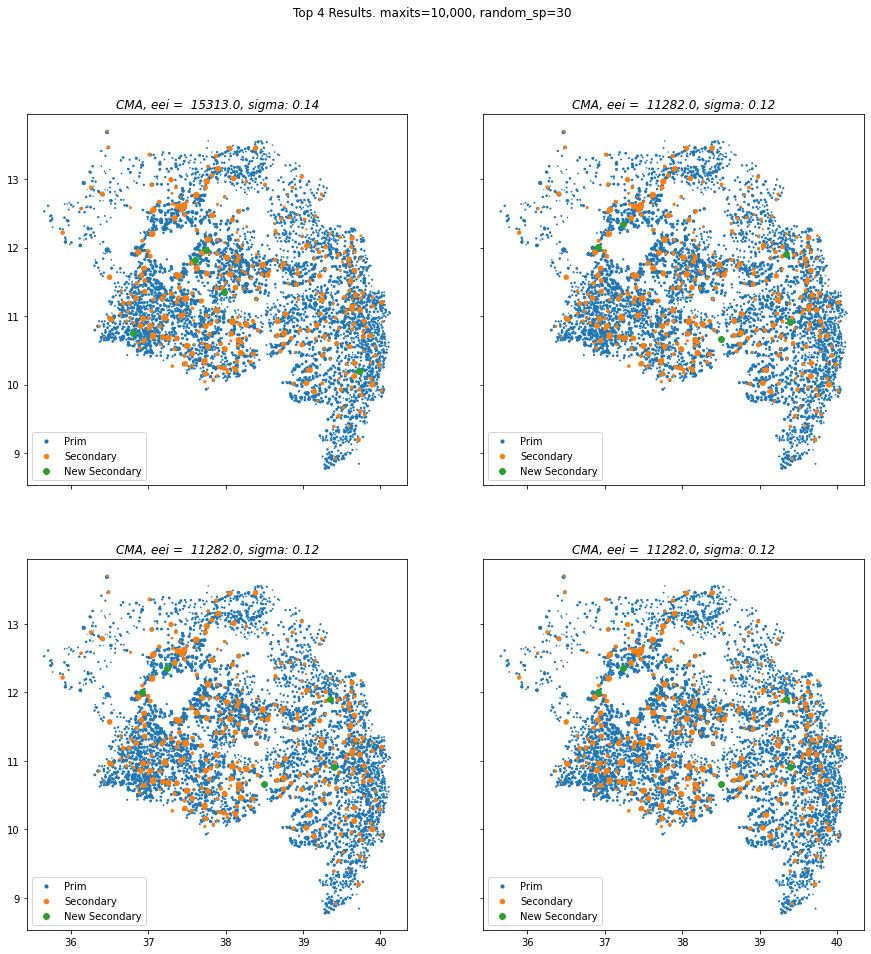

In [26]:
# Show results of top 4.
top_4 = results[:4]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Top 4 Results. maxits=10,000, random_sp=30')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(top_4['proposed_locations'][i][1::2], top_4['proposed_locations'][i][::2], s = 35, \
                     marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title((str(top_4.loc[i]['algorithm']) + ', eei =  ' + str(top_4.loc[i]['eei'])\
                       + ', sigma: ' + str(top_4.loc[i]['sigma'])), fontstyle='italic')

for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

In [151]:
es.result

CMAEvolutionStrategyResult(xbest=array([10.3496984 , 39.97361506, 12.0127347 , 39.11926458,  9.98947304,
       39.78531651, 11.20414389, 37.6112996 , 13.76056872, 36.00700862]), fbest=-441780.34098375135, evals_best=6946, evaluations=8500, iterations=850, xfavorite=array([10.34969835, 39.97361514, 12.01273464, 39.11926456,  9.98947297,
       39.78531651, 11.20414392, 37.61129957, 13.76056875, 36.00700849]), stds=array([0.00000002, 0.00000002, 0.00000002, 0.00000002, 0.00000003,
       0.00000002, 0.00000002, 0.00000003, 0.00000003, 0.00000002]), stop={'tolstagnation': 389})

In [ ]:
# now check how much this increases the GER for secondary enrollment. 
# find enrollment per new school. 

In [696]:
winner = top_4.head(1)
winner

,index,random_starting_point,algorithm,ee,eei,proposed_locations,time,sigma
0,34,4,CMA,449937.0,15313.0,"[11.349431324746357, 37.98200578177767, 10.755...",616.899975,0.14


In [32]:
new_loc = winner['proposed_locations'].to_numpy()
new_loc = new_loc[0].reshape(proposed_schools,2)
df_sec_new = np.append(df_sec_loc, new_loc).reshape(len(df_sec_loc)+len(new_loc //2),2)

In [38]:
closest_ss_current = np.min(haversine_vector(df_sec_loc, df_prim_loc, Unit.KILOMETERS, comb=True), axis=1)
closest_ss_current = np.sum(closest_ss_current) / len(df_sec_loc)
closest_ss_current

114.13260010811476

In [39]:
closest_ss_new = np.min(haversine_vector(df_sec_new, df_prim_loc, Unit.KILOMETERS, comb=True), axis=1)
closest_ss_new = np.sum(closest_ss_new) / len(df_sec_loc)
closest_ss_new

112.72647480674128

5145

In [77]:
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)

In [136]:
df_sec_enroll_new = df_sec_enroll.copy()
np.sum(df_sec_enroll_new)

434624.0

In [145]:
np.sum(df_sec_enroll)

434624.0

In [ ]:
# index of closest SS to PS
closest_sec_index = np.argmin(haversine_vector(df_prim_loc, df_sec_loc, Unit.KILOMETERS, comb=True), axis=0)
len(closest_sec_index)

In [547]:
closest

[[],
 [[3779, 2.4410683070009864], [3793, 1.9818459464365512]],
 [[2457, 3.823103306032864], [2462, 4.1319131848337225]],
 [[1219, 4.741522987739185],
  [1253, 4.543987468052105],
  [1256, 2.9652626251847307],
  [1257, 4.455041575881474],
  [1261, 1.8870139187632637]],
 []]

In [146]:
##### NEED TO UPDATE SECONDARY ENROLLMENT NOW. 
feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
d = haversine_vector(df_prim_loc, new_loc, Unit.KILOMETERS, comb=True)

for ss in range(0, proposed_schools): # for each secondary school
    for ps in range(0, len(d[ss])): # for each distance from a secondary school to a primary school                         
        # Case 0
        # if the distance is less than 5km & the distance is less than the current distance to old secondary school
        if (d[ss][ps] < 5) & (d[ss][ps] < current_ps_distance[ps]):
            if ps not in feeder: # if primary school not in feeder dict, add.
                feeder[ps] = [ss, d[ss][ps]] # dict = {primary school: [feeder secondary school, distance of ps to ss]}
            else: # if ps already a key in feeder, replace with min [feeder secondary school, distance of ps to ss]
                if feeder[ps][1] < d[ss][ps]:
                    feeder[ps] = [ss, d[ss][ps]]

            # case 1
            
            # Current estimated enrollment feeding into current SS
            distance_current = shape(current_ps_distance[ps], df_prim_enroll[ps])            
            df_sec_enroll_new[closest_sec_index[ps]] -= distance_current

In [147]:
keys = np.array(list(feeder.keys()))
ss = np.array(list(feeder.values()))[:,0].astype(int)
dist = np.array(list(feeder.values()))[:,1]
shapedx = shape(dist, df_prim_enroll[keys])

array([[13.16408878, 37.12869168],
       [11.99701586, 37.46077698],
       [10.7036779 , 36.49666711],
       [11.54643242, 38.72049619],
       [11.6124488 , 38.97651988]])

In [589]:
ee_old_constant = np.sum(df_sec_enroll)


In [594]:
closest

[[],
 [[3231, 3.3965317334134077],
  [4589, 4.1192270252595],
  [4590, 3.94202971244525],
  [4591, 2.599662462211267],
  [4592, 4.3868703392276345],
  [4593, 3.60114239153265]],
 [],
 [],
 [[4721, 4.771019524929969],
  [4733, 4.571997488811274],
  [4736, 4.1577411410691045],
  [4757, 4.828805136182356]]]

In [657]:
def get_close_schools(x):
    # get (index and distance) of schools located less than 5km and less than current distance.
    return [[i, x[i]] for i in range(len(x)) if ((x[i] < 5) & (x[i] < current_ps_distance[i]))]

In [672]:
feeder = {}
ee_old_constant = np.sum(df_sec_enroll)
ee_old = ee_old_constant
d = haversine_vector(df_prim_loc, generate_random_sp(), Unit.KILOMETERS, comb=True)
closest = [get_close_schools(d[i]) for i in range(proposed_schools)]

for ss in range(proposed_schools):
    for ps in range(len(closest[ss])):
        closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
        if closest_prim[0] not in feeder:
            feeder[closest_prim[0]] = [ss, closest_prim[1]]
        elif closest_prim[1] < feeder[closest_prim[0]][1]:
            feeder[closest_prim[0]] = [ss, closest_prim[1]]
            
        else:
            print('NOT SUPPOSED TO BE HERE.')
        # Current estimated enrollment feeding into current SS
        distance_current = shape(current_ps_distance[closest_prim[0]], df_prim_enroll[closest_prim[0]])
        ee_old -= distance_current # remove old secondary students within catchment.


                
# eei is only the final min schools being added.
closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
ps_enroll = df_prim_enroll[list(feeder.keys())]
eei = np.sum(shape(closest_ss_dist, ps_enroll))
ee = eei + ee_old # for overall expected enrollment. 
print(ee)

435533.5520687372


In [661]:
feeder

{3570: [0, 2.9923848336770393],
 3574: [0, 3.579847417281687],
 3581: [0, 1.1610762962381782],
 3584: [0, 0.2474953021544718],
 3586: [0, 2.211699103876387],
 3588: [0, 1.9663473378154546],
 3722: [0, 4.866754210253886],
 3553: [1, 1.5134299349844873],
 3555: [1, 0.930507276048547],
 3556: [1, 3.2525508132042673],
 3583: [1, 0.7892439487017284]}

In [665]:
ps_enroll = df_prim_enroll[list(feeder.keys())]
ps_enroll

array([ 152.,  257.,   79.,  409.,  320.,  368.,  336.,  126., 1010.,
        553.,  270.])

In [662]:
[row[1] for row in list(feeder.values())]

[2.9923848336770393,
 3.579847417281687,
 1.1610762962381782,
 0.2474953021544718,
 2.211699103876387,
 1.9663473378154546,
 4.866754210253886,
 1.5134299349844873,
 0.930507276048547,
 3.2525508132042673,
 0.7892439487017284]

In [566]:
feeder2.reshape((len(feeder2)//3, 2))

ValueError: cannot reshape array of size 27 into shape (9,2)

In [148]:
new_enroll_per_school = np.bincount(ss, weights=np.rint(shapedx))

In [149]:
np.sum(shapedx)

15983.048606074779

In [141]:
df_sec_enroll_new = np.append(df_sec_enroll_new, new_enroll_per_school)

In [142]:
np.sum(df_sec_enroll_new) - np.sum(df_sec_enroll)

15315.01269925444

In [143]:
np.sum(df_sec_enroll) + es.result[1]

-7156.340983751346

In [91]:
es.result[1]

-441780.34098375135

In [92]:
np.sum(df_sec_enroll)

434624.0

In [93]:
np.sum(df_sec_enroll_new)

433954.01269925444

### Below is testing code

In [ ]:
# Sample 5 coordinates. 
x = create_random_sp('woreda')
x = x.reshape(proposed_schools,2)

#####  Glossary
* ps = primary school
* ss = secondary school
* ee = expected enrollment
* eei = expected enrollment increase
* ee_old = current secondary enrollment
* current_ps_distance = exisitng distance to from primary school to secondary school


In [ ]:
eei = 0 
ee_old = np.sum(df_sec_enroll)


In [ ]:
min_distance = np.min(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0) # minimum distance 
less_than = np.where(min_distance < current_ps_distance)
eei = np.sum(shape(min_distance[less_than], df_prim_enroll[less_than]))
eei

In [ ]:
old_within_range = (min_distance > current_ps_distance) & (current_ps_distance < 5)
ee_old -= np.sum(shape(min_distance[old_within_range], df_prim_enroll[old_within_range]))
ee_old

In [ ]:
ee[:, np.any(ee ==True, axis = 0)]

In [ ]:
d[np.any(ee==True)]

In [ ]:
np.unique(np.where(ee), return_inverse=True, axis=0)

In [ ]:
print(current_ps_distance)

In [ ]:
d = haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True) # single loop over primary schools with dist to secondary
# feeder_dist = [[] for _ in range(proposed_schools)]
# feeder_ps =[[] for _ in range(proposed_schools)]
feeder = {}
eei = 0
ee_old = np.sum(df_sec_enroll)
for ss in range(0, proposed_schools):
    for ps in range(0, len(d[ss])):
        # if distance is < 5 and < current distance to primary school.
        if (d[ss][ps] < 5) & (d[ss][ps] < current_ps_distance[ps]):
            if len(feeder) == 0:
                feeder[ps] = [ss, d[ss][ps]] # keys are schools dist to closest school. 
            else:
                if ps not in feeder: # stops double counting
                    feeder[ps] = [ss, d[ss][ps]]
                else:
#                     # case zero, if ps_n < ps_n+1, replace school in feeder.
                    if feeder[ps][1] < d[ss][ps]: 
                        feeder[ps] = [ss, d[ss][ps]]
                        
# eei is only the final min schools being added.
closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
ps_enroll = df_prim_enroll[list(feeder.keys())]
eei = np.sum(shape(closest_ss_dist, ps_enroll))
eei

In [ ]:
d = haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True) # single loop over primary schools with dist to secondary
feeder = {}
eei = 0
ee_old = np.sum(df_sec_enroll)
ee_old

In [ ]:
for ss in range(0, proposed_schools): # for each secondary school
    for ps in range(0, len(d[ss])): # for each distance from a secondary school to a primary school
        
        # Case 0
        
        # if the distance is less than 5km & the distance is less than the current distance to old secondary school
        if (d[ss][ps] < 5) & (d[ss][ps] < current_ps_distance[ps]):
            if ps not in feeder: # if primary school not in feeder dict, add.
                feeder[ps] = [ss, d[ss][ps]] # dict = {primary school: [feeder secondary school, distance of ps to ss]}
            else: # if ps already a key in feeder, replace with min [feeder secondary school, distance of ps to ss]
                if feeder[ps][1] < d[ss][ps]:
                    feeder[ps] = [ss, d[ss][ps]]
        
        # Case 1. 
        # if ps distance is less than 5 but ps distance is > 
        elif (current_ps_distance[ps] < 5) & (d[ss][ps] < current_ps_distance[ps]):
            ee_old -= shape(current_ps_distance[ps], df_prim_enroll[ps])

# eei is only the final min schools being added.
closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
ps_enroll = df_prim_enroll[list(feeder.keys())]
eei = np.sum(shape(closest_ss_dist, ps_enroll))
ee = eei + ee_old

print(round(ee,0), round(eei,0), round(ee_old,0))

In [ ]:
np.unique(tt[:,1], return_inverse=True)

In [ ]:

np.argwhere(tt[:,1])
# np.unique(tt[:,0], return_inverse=True)
# for i in tt:
#     print(np.unique(i))

In [ ]:
rr = [i for i in d < 5]
rr = np.array(rr)
[d[i] for i in rr]

In [ ]:
a[:, np.all(a < 10, axis = 0)]

In [ ]:
d[:, np.all( d < 12, axis=0)]

In [ ]:
np.all(d<=5, axis=0)

In [ ]:
(d[:,np.any(d<5, axis=0)])

In [ ]:
np.all(d>5, axis=0)